In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
import os
import dhs_f
import fnmatch
import pyreadstat
import copy
#for meaningfull error messages turn of parallel_apply/ replace with apply
from pandarallel import pandarallel
import time
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import sys
from concurrent.futures import ProcessPoolExecutor
from functools import  partial

# Initialization
pandarallel.initialize()
# Get the absolute path of the parent directory of the directory of the script
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..")) + '/water_sven/'
# Append the parent directory to sys.path
print(parent_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
print(sys.path)
import helper_utils as hu
import visualizations as vis
import geo_utils as gu

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
/home/sven/pycharm/DHS
/home/sven/pycharm/water_sven/
['/home/sven/pycharm/DHS', '/home/sven/pycharm', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/mnt/datadisk/sharedPrograms/venv/water_2202_tf82/lib/python3.8/site-packages', '/home/sven/pycharm/water_sven/']


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
###Options
#since_year = 2012
#drop south africa, egypt, tunesia, morocco
#drop_survey = ['MDGE6AFL', EGGE61FL,GHGE7IFL,NMGE61FL,ZAGE71FL,maybe:KMGE61FL]
#drop surveys for splits
drop_survey = ['EGGE61FL', 'ZAGE71FL']
#drop_countries = ['ZA', 'EG', 'TN', 'MA']
###DHS Version 6: 2008-2013
min_dhs_version = 6
#only extracts locations where these survey records are available #'HR' = household recode
additional_files = ['HH', 'HR']
###Paths
dhs_path = r"/mnt/datadisk/data/surveys/DHS_raw_data/"
dhs_extras_p = r"/mnt/datadisk/data/surveys/DHS_info/"
img_path = '/mnt/datadisk2/preprocessed/all/996x996_c432_fillmean_m2.5_rlocal channel mean_clipvoutlier_normZ_f31213/'
#weighting of simplified water sources for PCA
drinking_water_source_weighting = 'drinking_water_source_weighting.csv'
projects_p = r"/mnt/datadisk/data/Projects/water/"
pickle_f = projects_p + '/inputs/pickle_tmp'
locations_f = projects_p + '/inputs/' + 'all_locations_final.csv'
#walk folder for finding .tifs
walk_f = r"/mnt/datadisk/"
#Saves loaded Questions/dfs into pickle and reloads because of runtime
load_from_pickle = True
#might be split into urban/rural as well cf. below
out_f = projects_p + 'inputs/water_labels_strat_split3.csv'
#export on HH level for further analysis (Imputation project Mrs. Pranti)
out_f_hh = projects_p + 'inputs/water_hh_all_strat_split2.csv'

#Select based on keywords (sometimes the column names and column codes vary slightly)
#need 2 values for iterating correctly
###Note:
#these are not known beforehand but retrieved and filtered in [4] by meta.column_names_to_labels.items()
#this is kinda cumbersome and results in lots of writing differences, not exact the same wording etc.
#The problem with using one meta for all Questionnaires is that they usually do not have all answer possibilities 
#for all questionnaires and these might differ from Questionnaire to Questionnaire as well (Maybe only version
#specific - I think the answer possibilities are phrased differently for some countries though)
columns_to_keep_n_rename = {
                            ('month', 'interview'): 'month of interview', 
                            ('year', 'interview'): 'year of interview', 
                            ('total members in household', False): 'number of household members',
                            ('time', 'to', 'water source'): 'time to get to water source (minutes)',
                            ('location', 'source for water'): 'location of source for water', 
                            ('water', 'shortage'): 'water shortages',
                            ('water', 'not available'): 'water shortages'
                           }
#Select based on exact match
exact_match = {'case identification', 'country code and phase', 'cluster number', 'region', 'district', 
               'anything done to water to make safe to drink',
               'household number', 'number of household members', 'source of drinking water', 
               'source of non-drinking water'}
#actually keep these columns (after renaming and looking at completness of data)
#dropped everything with scarce data
named_columns_to_keep = ["case identification", "country code and phase", "cluster number", "household number",
                         "month of interview", "year of interview", "number of household members", "region", 
                         "source of drinking water", "GEID", "water shortages", 
                         "time to get to water source (minutes)", "location of source for water", 
                         "anything done to water to make safe to drink", "month of interview", 
                         "district", 'water shortages']
#calculate separately for urban/rural
split_urban_rural = False
#limit by year NOT IMPLEMENTED
#min_year = False
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

In [4]:
###load data, preselect water columns and save into pickle for faster reloading
#Note: Important to use meta files since column names and especially value labels are unambiguous
#unify column names and replace values
column_names_d = {}
bottled_d = {}
counter = 0
counter2 = {}
if not os.path.isfile(pickle_f) or not load_from_pickle:
    dhs_d_all, country_d, data_file_types_d, typ_l, dhs_dirs_d = \
        dhs_f.load_dhs_data(dhs_path, dhs_extras_p)
    pathes = {}
    
    #catch all files
    for i, types in dhs_d_all.items():
        #only extract files where Household Recode data is available
        for additional_file in additional_files:
            if 'GE' in types and additional_file in types:
                #only use HH if HR not available
                if additional_file == 'HR' or 'HR' not in types:
                    if int(i[2]) >= min_dhs_version:
                        for (dirrpath, dirrnames, filenames) in os.walk(dhs_dirs_d[i][types.index(additional_file)]):
                            for file in filenames:
                                if fnmatch.fnmatch(file, '*.sav') or fnmatch.fnmatch(file, '*.SAV'):
                                    #also get GE folder for matching
                                    splitted_p = os.path.normpath(dhs_dirs_d[i][types.index('GE')]).split(os.sep)
                                    pathes[splitted_p[-1]] = dirrpath + '/' + file
    print(len(pathes), pathes)
    df_l = []
    meta_l = []
    
    #iterate over files and replace numerical values and cryptic column names with actual values
    for n, (ge_f, path) in enumerate(pathes.items()):
        print('________________________', n, '(', len(pathes), ')', ' __________________________________')
        print(path)
        print(ge_f)
        df, meta = pyreadstat.read_sav(path, encoding='LATIN1')
        new_columns = {}
        v_s = set([])
        for column_code, column_name in meta.column_names_to_labels.items():
            #to show and find all relevant columns to do: export to csv?
            #Note not all column codes and column names are uniquee and written consistently
            if column_name[:2].lower() != 'na':
                #print(column_code, column_name)
                for match_k, new_name in columns_to_keep_n_rename.items():
                    matched = True
                    new_name = new_name.lower()
                    for match_w in match_k:
                        if match_w:
                            if match_w not in column_name.lower():
                                matched = False
                    if matched:
                        #expensive so create only when matched
                        add_name = [column_name, column_code] + list(range(100))
                        #ensure uniqueness
                        nr = 0
                        while new_name in new_columns.values():
                            new_name = new_name + ' ' + add_name[nr]
                            nr += 1
                        new_columns[column_code] = new_name
                        print('hello', column_code, column_name, '-->', new_name)
    #                     if column_code in meta.variable_value_labels.keys():
    #                         print(meta.variable_value_labels[column_code])
                if column_name.lower() in exact_match:
                    add_name = [column_name, column_code] + list(range(100))
                    new_name = column_name.lower()
                    #ensure uniqueness
                    nr = 0
                    while new_name in new_columns.values():
                        new_name = new_name + ' ' + add_name[nr]
                        nr += 1
                    new_columns[column_code] = new_name
                    print('hello2', column_code, new_name)
#                 elif 'water' in column_name.lower():
#                     add_name = [column_name, column_code] + list(range(100))
#                     new_name = column_name.lower()
#                     #ensure uniqueness
#                     nr = 0
#                     while new_name in new_columns.values():
#                         new_name = new_name + ' ' + add_name[nr]
#                         nr += 1
#                     new_columns[column_code] = new_name
#                     print('hello3', column_code, new_name)
    #                     if column_code in meta.variable_value_labels.keys():
    #                         print(meta.variable_value_labels[column_code])
        print('1')
        #replace int values with meaningful names
        variable_values_d = {}
        for col_n in new_columns.keys():
            if col_n in meta.variable_value_labels.keys():
                variable_values_d[col_n] = {}
                for k, v in meta.variable_value_labels[col_n].items():
                    if type(v) == str:
                        variable_values_d[col_n][k] = v.lower()
                    else:
                        variable_values_d[col_n][k] = v
#                 print('values d', col, dic)

        df = df.replace(variable_values_d)
        #only use matched columns
        df = df[df.columns.intersection(new_columns.keys())]              
        #rename columns to uniform names
        df = df.rename(columns=new_columns)
        #add GEID for matching files
        df["GEID"] = ge_f
#         df = df.reset_index()
#         if ge_f not in drop_survey:
#             df_l.append(df)
#             meta_l.append(meta)
#         else:
#             print('dropped', df["GEID"])
        # df_l.append(df)

    print('final bottled counter', counter)
    print('final bottled counter', counter2)
    for k, v in counter2.items():
        print(k, v)
    for k, v in bottled_d.items():
        print(k, v)
#         print(df)

    with open(pickle_f, 'wb') as pf:
        pickle.dump(df_l, pf)
else:
    with open(pickle_f, 'rb') as pf:
        df_l = pickle.load(pf)
        

In [5]:
df2_l = []
#concatenating
for df in df_l:
    vc = pd.DataFrame(df.columns.value_counts())
    # print(vc[vc[0] >= 2], type(vc))
    # print(df)
    # if df['GEID'].iloc[0] not in drop_survey:
    df2_l.append(df)
    # else:
    #     print('dropped', df["GEID"])
    # print(df.columns)
print('_________________________________________')
df = pd.concat(
    df2_l,
    axis=0,
    join="outer",
    # ignore_index=True,
    # keys=None,
    # levels=None,
    # names=None,
    verify_integrity=False,
    # copy=True,
)

df#[(df['case identification'] == '03020002')]# & (df["region"] == 'dire dawa')]

_________________________________________


,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,source of non-drinking water,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,month of interview Month of household interview (Ethiopia calendar),district,region Region,source of drinking water Source of drinking water,month of interview Month of interview,month of interview Month of interview SBINTM$02,month of interview Month of interview SBINTM$03,month of interview Month of interview SBINTM$04,month of interview Month of interview SBINTM$05,month of interview Month of interview SBINTM$06,month of interview Month of interview SBINTM$07,month of interview Month of interview SBINTM$08,month of interview Month of interview SBINTM$09,month of interview Month of interview SBINTM$10,month of interview Month of interview SBINTM$11,month of interview Month of interview SBINTM$12,month of interview Month of interview SBINTM$13,month of interview Month of interview SBINTM$14,month of interview Month of interview SBINTM$15,month of interview Month of interview SBINTM$16,year of interview Year of interview,year of interview Year of interview SBINTY$02,year of interview Year of interview SBINTY$03,year of interview Year of interview SBINTY$04,year of interview Year of interview SBINTY$05,year of interview Year of interview SBINTY$06,year of interview Year of interview SBINTY$07,year of interview Year of interview SBINTY$08,year of interview Year of interview SBINTY$09,year of interview Year of interview SBINTY$10,year of interview Year of interview SBINTY$11,year of interview Year of interview SBINTY$12,year of interview Year of interview SBINTY$13,year of interview Year of interview SBINTY$14,year of interview Year of interview SBINTY$15,year of interview Year of interview SBINTY$16,water shortages How often water shortages,water shortages Number of days of water shortages,source of drinking water source of drinking water
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10529,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,NaN,no,on premises,in own yard/plot,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10530,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,NaN,no,on premise

In [6]:
#look at completness of data
df.describe(include='all')

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,source of non-drinking water,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,month of interview Month of household interview (Ethiopia calendar),district,region Region,source of drinking water Source of drinking water,month of interview Month of interview,month of interview Month of interview SBINTM$02,month of interview Month of interview SBINTM$03,month of interview Month of interview SBINTM$04,month of interview Month of interview SBINTM$05,month of interview Month of interview SBINTM$06,month of interview Month of interview SBINTM$07,month of interview Month of interview SBINTM$08,month of interview Month of interview SBINTM$09,month of interview Month of interview SBINTM$10,month of interview Month of interview SBINTM$11,month of interview Month of interview SBINTM$12,month of interview Month of interview SBINTM$13,month of interview Month of interview SBINTM$14,month of interview Month of interview SBINTM$15,month of interview Month of interview SBINTM$16,year of interview Year of interview,year of interview Year of interview SBINTY$02,year of interview Year of interview SBINTY$03,year of interview Year of interview SBINTY$04,year of interview Year of interview SBINTY$05,year of interview Year of interview SBINTY$06,year of interview Year of interview SBINTY$07,year of interview Year of interview SBINTY$08,year of interview Year of interview SBINTY$09,year of interview Year of interview SBINTY$10,year of interview Year of interview SBINTY$11,year of interview Year of interview SBINTY$12,year of interview Year of interview SBINTY$13,year of interview Year of interview SBINTY$14,year of interview Year of interview SBINTY$15,year of interview Year of interview SBINTY$16,water shortages How often water shortages,water shortages Number of days of water shortages,source of drinking water source of drinking water
count,944312,944312,9.706360e+05,970636.000000,970636.0,970636.000000,970636.000000,920739,968732,970636,38206,179755,910990,716814,761790,25313.000000,236777.0,24342,24505,5993.000000,4374.000000,1595.000000,746.000000,319.000000,155.000000,65.000000,30.000000,10.000000,4.00000,3.000000,3.000000,3.000000,3.000000,2.0,0.0,5993.0,4374.0,1595.0,746.0,319.0,155.0,65.0,30.0,10.0,4.0,3.0,3.0,3.0,3.0,2.0,0.0,2978,2974,11340
unique,497128,61,NaN,NaN,21.0,NaN,NaN,394,69,87,25,6,286,3,3,NaN,798.0,27,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,19
top,10118,NG6,NaN,NaN,11.0,NaN,NaN,central,tube well or borehole,NGGE7BFL,public tap/standpipe,"no, not interrupted for a full day",on premises,elsewhere,no,NaN,4.0,moyenne guinée,tube well or borehole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rarely,many hours,protected public well
freq,24,52162,NaN,NaN,110253.0,NaN,NaN,23375,183740,40427,9473,103065,254095,643871,602596,NaN,3400.0,2072,7159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1217,2461,3739
mean,NaN,NaN,1.302480e+05,190.031952,NaN,2014.080770,5.035715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.516375,NaN,NaN,NaN,7.498415,7.396205,7.310345,7.218499,7.194357,7.258065,7.076923,7.200000,6.800000,6.50000,6.666667,6.666667,6.666667,6.666667,7.0,NaN,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,NaN,NaN,NaN,NaN
std,NaN,NaN,8.659105e+05,941.139743,NaN,3.265996,3.281107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.239645,NaN,NaN,NaN,1.014106,1.029452,1.104167,1.118115,1.205269,1.252731,1.253840,1.399507,0.632456,0.57735,0.577350,0.577350,0.577350,0.577350,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [7]:
#look at completness of data
# for col in df.columns:
#     print(df[col].value_counts(dropna=False))

In [8]:
#clean up/make ints in time to get to water source (minutes)
to_replace = {'time to get to water source (minutes)':
                  {'300+': 300, '500+': 500, 'don\'t know': np.NaN, '995+': 500,
                   'Don\'t know': np.NaN, '': np.NaN, '500 +': 500, 'NaN': np.NaN, 'less than  minute': 1},#, ' ': 
                 # np.NaN, '  ': np.NaN, '   ': np.NaN, },
              'source of drinking water': {'nan': np.NaN, 'NaN': np.NaN},
                'month of interview': {'may': 5, 'april': 4, 'march': 3, 'october': 10, 'june': 6, 'february': 2,
                                       'november': 11, 'december': 12, 'july': 7},
             'water shortages': {'no, not interrupted for a full day': 0,
                                 'yes, interrupted for a full day or more': 1,
                                 'yes': 1,
                                 'yes, interruped for a full day or more': 1,
                                 'no': 0,
                                 "don't know": np.NaN}}
# 'location of source for water': {'In own yard/plot': 5, 'In own dwelling': 0, 'Elsewhere': 10,
#                                  'NaN': np.NaN}}
df = df.replace(to_replace)
df = df[df.columns.intersection(named_columns_to_keep)]
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10529,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,0.0,on premises,in own yard/plot,yes,NaN
10530,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,0.0,on premises,in own yard/plot,no,NaN
10531,400 27,ZW7,400.0,27.0,11.0,2015.0,5.0,mashonaland east,unprotected well,ZWGE72FL,0.0,10.0,elsewhere,yes,NaN
10532,400 28,ZW7,400.0,28.0,11.0,2015.0,8.0,mashonaland east,protected well,ZWGE72FL,0.0,on premises,in own yard/plot,no,NaN


In [9]:
locations_df = pd.read_csv(locations_f)
locations_df = locations_df[["DHSID", "country", "DHSYEAR", "URBAN_RURA", "LATNUM", "LONGNUM", "adm0_name", "adm1_name", "adm2_name", "GEID", "TIF_name"]]
locations_df['DHSYEAR'] = locations_df['DHSYEAR'].astype(int)
locations_df['TIF_name'] = locations_df['TIF_name'].str[:] + '.tif'
locations_df

,DHSID,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name
0,AO200600000001,Angola,2006,U,-12.169283,13.859255,Angola,Benguela,Lobito,AOGE52FL,AOGE52FL00000001.tif
1,AO200600000002,Angola,2006,U,-12.167753,13.845458,Angola,Benguela,Lobito,AOGE52FL,AOGE52FL00000002.tif
2,AO200600000003,Angola,2006,U,-12.747312,13.607121,Angola,Benguela,Benguela,AOGE52FL,AOGE52FL00000003.tif
3,AO200600000004,Angola,2006,U,-11.502919,14.060841,Angola,Cuanza Sul,Sumbe,AOGE52FL,AOGE52FL00000004.tif
4,AO200600000005,Angola,2006,U,-8.581393,13.666062,Angola,Bengo,Dande,AOGE52FL,AOGE52FL00000005.tif
...,...,...,...,...,...,...,...,...,...,...,...
64698,ZW201500000396,Zimbabwe,2015,U,-17.915288,31.156115,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000396.tif
64699,ZW201500000397,Zimbabwe,2015,R,-18.379501,31.872287,Zimbabwe,Manicaland,Makoni,ZWGE72FL,ZWGE72FL00000397.tif
64700,ZW201500000398,Zimbabwe,2015,R,-16.660612,29.850649,Zimbabwe,Mashonaland West,Hurungwe,ZWGE72FL,ZWGE72FL00000398.tif
64701,ZW201500000399,Zimbabwe,2015,U,-17.914251,30.956975,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000399.tif


In [10]:
#to map locations with HH of questionnaire we need to generate a DHSID, which is a bit complicated because the
#year_of_interview is not necessarily the same as the year used in the locations_df. In locations_df /the GE files
#it will always be the starting year of the questionnaire (with some exceptions when starting in NOV/DEZ) and
#in year_of_interview is when the interview actually happened
min_dict = {}
def fixDHSID(row):
    """we need to get the DHSYEAR from shp files since it is actually not guaranteed to be the same as the 
    'year of interview'"""
    if row["GEID"] not in min_dict:
        sub_df = locations_df[locations_df["GEID"] == row["GEID"]]["DHSYEAR"]
        if len(sub_df.value_counts()) >= 2:
            print(sub_df)
            print(sub_df.value_counts)
            raise Exception('This should not happen')
        new_year = min(sub_df)
        min_dict[row["GEID"]] = new_year
    else:
        new_year = min_dict[row["GEID"]]
    return row["GEID"][:2] + str(int(float(new_year))) + str(int(row["cluster number"])).zfill(8)

In [11]:
#create IDs for matching with files/geolocations
df['DHSID'] = df.parallel_apply(fixDHSID, axis=1)
#df["TIF_name"] = df["GEID"] + df["cluster number"].astype(int).astype(str).str.zfill(8) + '.tif'
df = pd.merge(df, locations_df[["DHSID", "URBAN_RURA"]], how="left", on="DHSID")
df['DHS survey ID'] = df['DHSID'].str[:6]
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,URBAN_RURA,DHS survey ID
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970631,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,0.0,on premises,in own yard/plot,yes,NaN,ZW201500000400,R,ZW2015
970632,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,0.0,on premises,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015
970633,400 27,ZW7,400.0,27.0,11.0,2015.0,5.0,mashonaland east,unprotected well,ZWGE72FL,0.0,10.0,elsewhere,yes,NaN,ZW201500000400,R,ZW2015
970634,400 28,ZW7,400.0,28.0,11.0,2015.0,8.0,mashonaland east,protected well,ZWGE72FL,0.0,on premises,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015


In [12]:
df[df['DHSID'] == 'ET201900000302']

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,URBAN_RURA,DHS survey ID
236204,03020002,ET7,302.0,2.0,8.0,2011.0,7.0,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
236205,03020010,ET7,302.0,10.0,8.0,2011.0,8.0,dire dawa,protected well,ETGE81FL,NaN,240.0,elsewhere,NaN,NaN,ET201900000302,R,ET2019
236206,03020018,ET7,302.0,18.0,8.0,2011.0,2.0,dire dawa,public tap/standpipe,ETGE81FL,NaN,20.0,elsewhere,NaN,NaN,ET201900000302,R,ET2019
236207,03020025,ET7,302.0,25.0,8.0,2011.0,2.0,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
236208,03020033,ET7,302.0,33.0,8.0,2011.0,2.0,dire dawa,public tap/standpipe,ETGE81FL,NaN,15.0,elsewhere,NaN,NaN,ET201900000302,R,ET2019
236209,03020041,ET7,302.0,41.0,8.0,2011.0,3.0,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
236210,03020049,ET7,302.0,49.0,8.0,2011.0,5.0,dire dawa,protected well,ETGE81FL,NaN,240.0,elsewhere,NaN,NaN,ET201900000302,R,ET2019
236211,03020056,ET7,302.0,56.0,8.0,2011.0,7.0,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
236212,03020064,ET7,302.0,64.0,8.0,2011.0,3.0,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
236213,03020072,ET7,302.0,72.0,8.0,2011.0,7.0,dire dawa,public tap/standpipe,ETGE81FL,NaN,60.0,elsewhere,NaN,NaN,ET201900000302,R,ET2019


In [13]:
#look at completness of data from selected rows
# for col in named_columns_to_keep:
#     print(df[col].value_counts(dropna=False))

In [14]:
def water_source_renaming(row):
    """simplifying water source labels"""
    if type(row) is float:
        if pd.isna(row):
            return_v = np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'unprotected' in row:
            if 'well' in row:
                return_v = 'unprotected well'
            elif 'spring' in row:
                return_v = 'unprotected spring'
        elif 'protected' in row:
            if 'well' in row:
                return_v = 'protected well'
            elif 'spring' in row:
                return_v = 'protected spring'
        #assuming open is unprotected
        elif 'open' in row and 'well' in row:
            return_v = 'unprotected well'
        elif 'sachet' in row or 'bag water' in row \
                or 'water in plastic bag' in row:
            return_v = 'sachet'
        elif 'bottled' in row:
            return_v = 'bottled'
        elif 'borehole' in row:
            return_v = 'tube well or borehole'
        elif 'truck' in row or 'cart' in row or \
                'vendor' in row or 'tanker' in row or \
                'bicycle' in row or 'motorcycle' in row:
            return_v = 'street vendor'
        elif 'river' in row or 'gravity flow scheme' in row:
            return_v = 'surface water'
        elif 'dam' in row or 'pond' in row:
            return_v = 'surface water'
        elif "neighbor's tap" in row \
            or "piped to neighbour's house" in row  \
                or "piped from the neighbor" in row\
                or "neighbour's tap" in row\
                or "private tap/neighbor" in row\
                or "neighbor's house" in row:
            return_v = 'piped to neighbor'
        elif "neighborhood" in row:
            return_v = 'other'
        elif "spring" == row:
            return_v = "unprotected spring"
        elif "public fountain" in row:
            return_v = "other"
        else:
            return_v = row
        # print(row, return_v)
    return return_v


def water_source_renaming_cat(row):
    """create label based on key words: well, spring, pipe, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'tube well or borehole'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'well'
        elif 'spring' in row:
            return 'spring'
        elif 'piped' in row or 'public tap/standpipe' == row:
            return 'piped'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'
        
        
def water_source_renaming_cat_urban(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'piped' in row or 'public tap/standpipe' == row:
            return 'piped'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'
        

def water_source_renaming_cat_piped1(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'piped into dwelling' == row:
            return 'piped into dwelling'
        elif 'piped' in row or 'public tap/standpipe' == row:
            return 'other piped'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'


def water_source_renaming_cat_piped2(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'pipe' in row:
            return row
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'

        

def water_source_renaming_cat_piped3(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'piped into dwelling' == row:
            return row
        elif 'piped to yard/plot' == row:
            return row
        elif 'pipe' in row:
            return 'piped (public/neighbor)'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'

In [15]:
#create simplified drinking water source
df['source of drinking water (simplified)'] = df['source of drinking water'].parallel_apply(water_source_renaming)
print('-------------after replacing and simplifying--------------')
for col in ['source of drinking water (simplified)']:
    print(df[col].value_counts(dropna=False))

-------------after replacing and simplifying--------------
tube well or borehole    194828
public tap/standpipe     143425
unprotected well         108259
surface water             95315
protected well            85581
piped to yard/plot        82574
piped into dwelling       76115
unprotected spring        52864
protected spring          49638
piped to neighbor         26500
sachet                    21555
street vendor             10847
rainwater                  9022
bottled                    6462
other                      5747
NaN                        1904
Name: source of drinking water (simplified), dtype: int64


In [16]:
df['source of drinking water (categorized by type)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat)
df['source of drinking water (categorized piped)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_piped1)
df['source of drinking water (categorized piped 2)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_piped2)
df['source of drinking water (categorized piped 3)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_piped3)
df['source of drinking water (categorized urban)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_urban)

print('-------------after replacing and simplifying--------------')
for col in ['source of drinking water (categorized by type)', 'source of drinking water (categorized urban)']:
    print(df[col].value_counts(dropna=False))

-------------after replacing and simplifying--------------
piped                    328614
tube well or borehole    194828
well                     193840
spring                   102502
surface water             95315
bottled                   28017
other                     14769
street vendor             10847
NaN                        1904
Name: source of drinking water (categorized by type), dtype: int64
groundwater      491170
piped            328614
surface water     95315
bottled           28017
other             14769
street vendor     10847
NaN                1904
Name: source of drinking water (categorized urban), dtype: int64


In [17]:
#create further labels and inputs for pca
categories_d = {}
weighting_d = {}
with open(drinking_water_source_weighting) as f:
    reader = csv.reader(f)
    for row in reader:
        categories_d[row[0]] = row[2].strip(' ')
        weighting_d[row[0]] = int(row[1])

df["source of drinking water (categorized)"] = df["source of drinking water (simplified)"].replace(categories_d)
df["source of drinking water (weights)"] = df["source of drinking water (simplified)"].replace(weighting_d)
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,URBAN_RURA,DHS survey ID,source of drinking water (simplified),source of drinking water (categorized by type),source of drinking water (categorized piped),source of drinking water (categorized piped 2),source of drinking water (categorized piped 3),source of drinking water (categorized urban),source of drinking water (categorized),source of drinking water (weights)
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970631,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,0.0,on premises,in own yard/plot,yes,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0
970632,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,0.0,on premises,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0
970633,400 27,ZW7,400.0,27.0,11.0,2015.0,5.0,mashonaland east,unprotected well,ZWGE72FL,0.0,10.0,elsewhere,yes,NaN,ZW201500000400,R,ZW2015,unprotected well,well,groundwater,groundwater,groundwater,groundwater,elementary,2.0
970634,400 28,ZW7,400.0,28.0,11.0,2015.0,8.0,mashonaland east,protected well,ZWGE72FL,0.0,on premises,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0


In [18]:
df[df["time to get to water source (minutes)"] == 'on premises'][["time to get to water source (minutes)", "source of drinking water (simplified)"]].value_counts()


time to get to water source (minutes)  source of drinking water (simplified)
on premises                            piped to yard/plot                       79247
                                       piped into dwelling                      74461
                                       protected well                           19600
                                       piped to neighbor                        19226
                                       unprotected well                         18606
                                       tube well or borehole                    13607
                                       rainwater                                 7361
                                       public tap/standpipe                      6785
                                       sachet                                    5264
                                       bottled                                   2971
                                       street vendor           

In [19]:
def refurbish_time_to_get_to_water_source(row):
    if pd.isna(row["time to get to water source (minutes)"]):
        if row["source of drinking water (simplified)"] == 'piped into dwelling':
            return 0
        elif row["source of drinking water (simplified)"] == 'piped to yard/plot':
            return 1
    elif row["time to get to water source (minutes)"] == 'on premises':
        if row["source of drinking water (simplified)"] in ["piped to yard/plot", "protected well", "unprotected well", "tube well or borehole", "piped to neighbor"]:
            return 1
        elif row["source of drinking water (simplified)"] in ["piped into dwelling"]:
            return 0
        else:
            return 5
    else:
        return row["time to get to water source (minutes)"]
    

def refurbish_location_of_source_for_water(row):
    #assuming based on categories that it is elsewhere
    elsewhere_s = {'public tap/standpipe', 'stream', 'sachet', 'street vendor', 'bottled', 'piped to neighbor', 
                  'rainwater', 'surface water', 'protected spring', 'unprotected spring'}
    if pd.isna(row["location of source for water"]):
        if row["source of drinking water (simplified)"] == 'piped into dwelling':
            return 'in own dwelling'
        elif row["source of drinking water (simplified)"] == 'piped to yard/plot':
            return 'in own yard/plot'
        elif row["source of drinking water (simplified)"] in elsewhere_s:
            return 'elsewhere'
        #assuming based on categories (mainly well types or other, that it is on the own yard/plot)
        elif row["time to get to water source (refurbished)"] == 0:
            return 'in own yard/plot'
        #data shows it's valid to assume everything >= 3 minutes is elsewhere, with very little exceptions
        elif row["time to get to water source (refurbished)"] >= 3:
            return 'elsewhere'
    else:
        return row["location of source for water"]
    

#deprecated
def refurbish_location_of_source_for_water2(row):
    elsewhere_s = {'public tap/standpipe', 'stream', 'sachet', 'street vendor', 'bottled', 'piped to neighbor', 
                  'rainwater', 'surface water', 'protected spring', 'unprotected spring'}
    if pd.isna(row["location of source for water"]):
        if row["source of drinking water (simplified)"] == 'piped into dwelling':
            return 'in own dwelling'
        elif row["source of drinking water (simplified)"] == 'piped to yard/plot':
            return 'in own yard/plot'
        elif row["source of drinking water (simplified)"] in elsewhere_s:
            return 'elsewhere'
#         elif row["time to get to water source (minutes)"] == 0:
#             return 'in own yard/plot'
        #data shows it's valid to assume everything >= 3 minutes is elsewhere, with very little exceptions
        elif row["time to get to water source (minutes)"] >= 3:
            return 'elsewhere'
    else:
        return row["location of source for water"]        

In [20]:
for col in df.columns[-10:]:
    print(df[col].value_counts(dropna=False))

R      622677
U      336801
NaN     11158
Name: URBAN_RURA, dtype: int64
NG2018    40427
NG2013    38522
KE2014    36430
EG2014    28175
MW2015    26361
GH2017    26324
MW2010    24825
UG2016    19588
CD2013    18171
BJ2012    17422
TD2014    17233
ET2010    16702
ET2016    16650
AO2015    16109
BU2016    15977
ZM2013    15920
BF2010    14424
CM2011    14214
BJ2017    14156
MZ2011    13919
SL2019    13399
RW2019    12949
ZM2018    12831
RW2014    12699
SL2013    12629
TZ2015    12563
RW2010    12540
GH2014    11835
CM2018    11710
UG2010    11340
MD2016    11284
ZA2017    11083
NI2012    10750
ZW2015    10534
ML2012    10105
TZ2012    10040
NM2013     9849
ZW2010     9756
GA2012     9755
CI2012     9686
TZ2010     9623
TG2013     9549
ML2018     9510
LS2014     9402
LS2009     9391
LB2013     9333
TZ2017     9330
LB2019     9068
UG2011     9033
UG2018     8957
ET2019     8663
BU2010     8596
MD2013     8574
SN2017     8380
MD2011     8094
AO2011     8030
KE2020     7952
GN2018     7912

In [21]:
df["time to get to water source (refurbished)"] = df.parallel_apply(refurbish_time_to_get_to_water_source, axis=1)
df["location of source for water (refurbished)"] = df.parallel_apply(refurbish_location_of_source_for_water, axis=1)
# df["location of source for water (refurbished 2)"] = df.parallel_apply(refurbish_location_of_source_for_water2, axis=1)

In [22]:
#--> let's assume everything >= 3 minutes is elsewhere
# sub_df = df[df["time to get to water source (refurbished)"] <= 5]
df[["location of source for water (refurbished)", "time to get to water source (refurbished)"]].value_counts(dropna=False)

location of source for water (refurbished)  time to get to water source (refurbished)
in own yard/plot                            1.0                                          119553
elsewhere                                   10.0                                         113263
                                            30.0                                         101561
in own dwelling                             0.0                                           76098
elsewhere                                   5.0                                           75831
                                            20.0                                          71207
                                            15.0                                          66492
                                            60.0                                          62174
                                            NaN                                           51480
                                            1.0   

In [23]:
df[df["time to get to water source (refurbished)"].isna()][["source of drinking water (simplified)", "location of source for water (refurbished)"]].value_counts(dropna=False)
df["time to get to water source (minutes)"] = df["time to get to water source (minutes)"].replace({"on premises": np.NaN})

In [24]:
df["penalty (location)"] = df["location of source for water (refurbished)"].replace({'in own dwelling': 0, 'in own yard/plot': 5, 'elsewhere': 10})
df["weighting (location)"] = df["location of source for water (refurbished)"].replace({'in own dwelling': 5, 'in own yard/plot': 3, 'elsewhere': 1})
df["time to get to water source (refurbished) + penalty"] = df["time to get to water source (refurbished)"] + df["penalty (location)"]
df["time to get to water source (refurbished) + penalty (capped)"] = df["time to get to water source (refurbished) + penalty"].parallel_apply(lambda x: x if x < 310 or np.isnan(x) else 310)

In [25]:
# for col in ["location of source for water (refurbished)", "time to get to water source (refurbished)",
#             "source of drinking water (simplified)",
#             "source of drinking water (weights)",
#            "source of drinking water (categorized)", "time to get to water source (refurbished) + penalty (capped)"]:
#     print(df[col].value_counts(dropna=False))

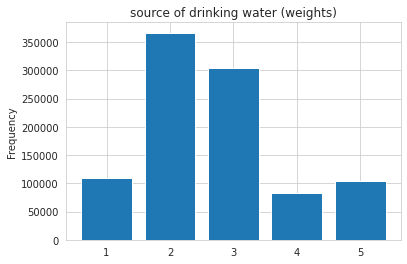

In [26]:
for col in ["source of drinking water (weights)"]:
    hist = df[col].plot.hist(bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], rwidth=0.8)
#     plt.xlim(0.5, 5.5)
    plt.title(col)
    plt.show()

time to get to water source (minutes)
(-4, 160, 5)


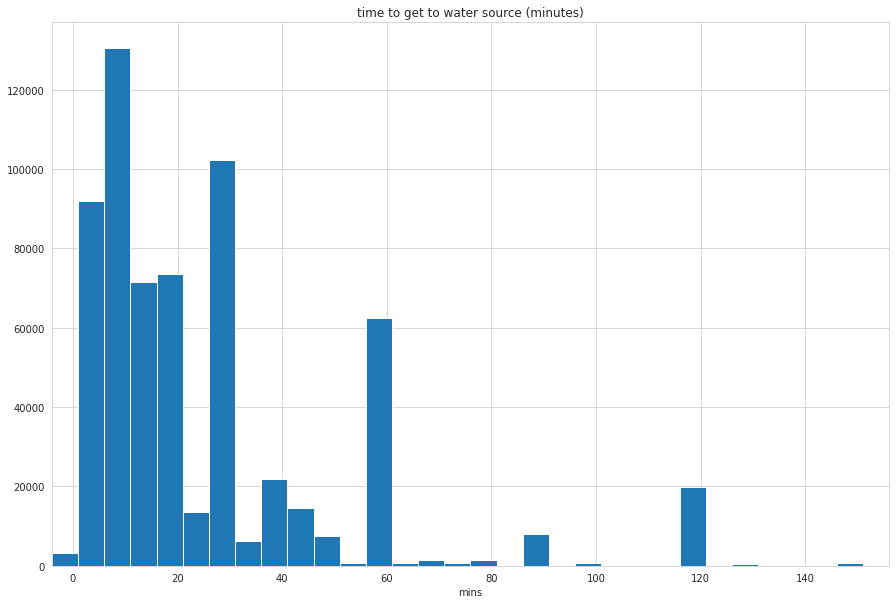

time to get to water source (minutes)
(-4, 1000, 20)


<Figure size 432x288 with 0 Axes>

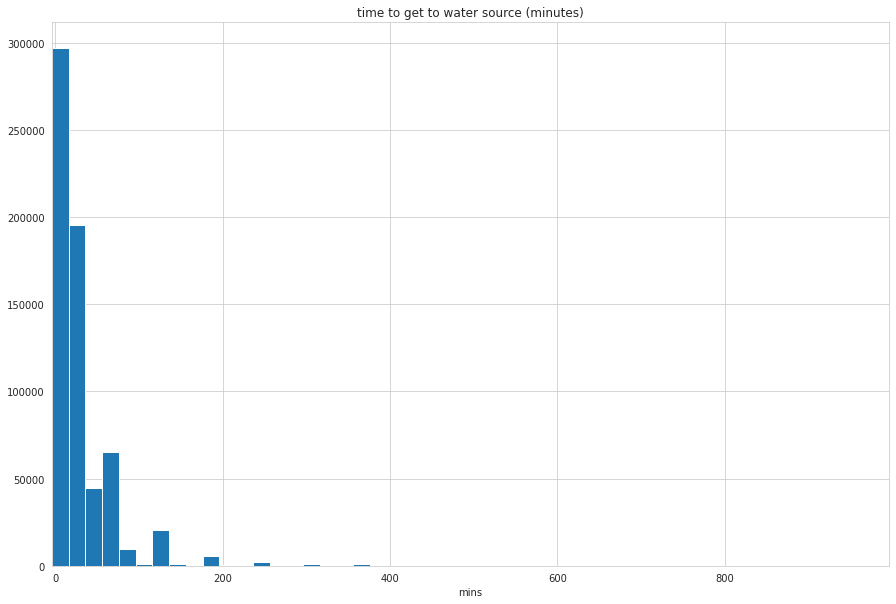

time to get to water source (minutes)
(150, 1000, 20)


<Figure size 432x288 with 0 Axes>

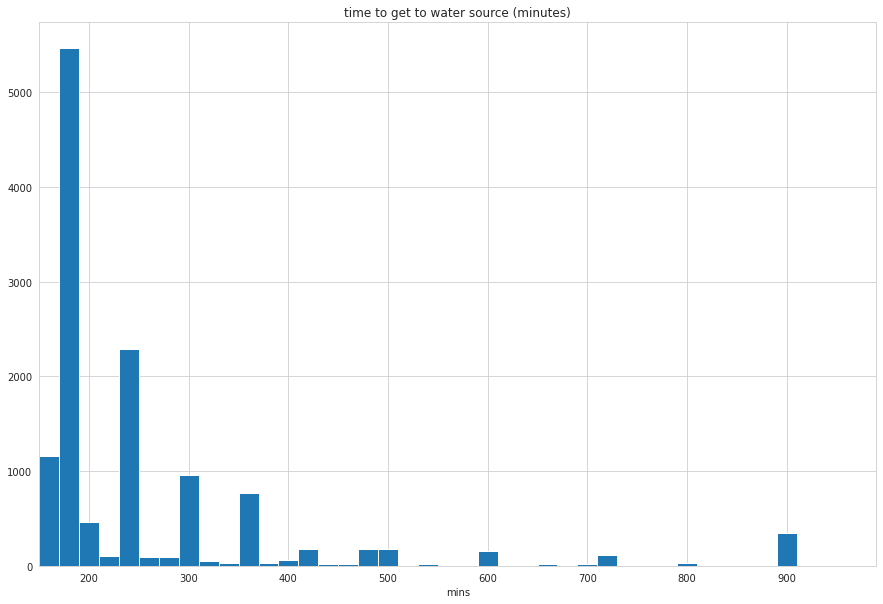

time to get to water source (refurbished)
(-4, 160, 5)


<Figure size 432x288 with 0 Axes>

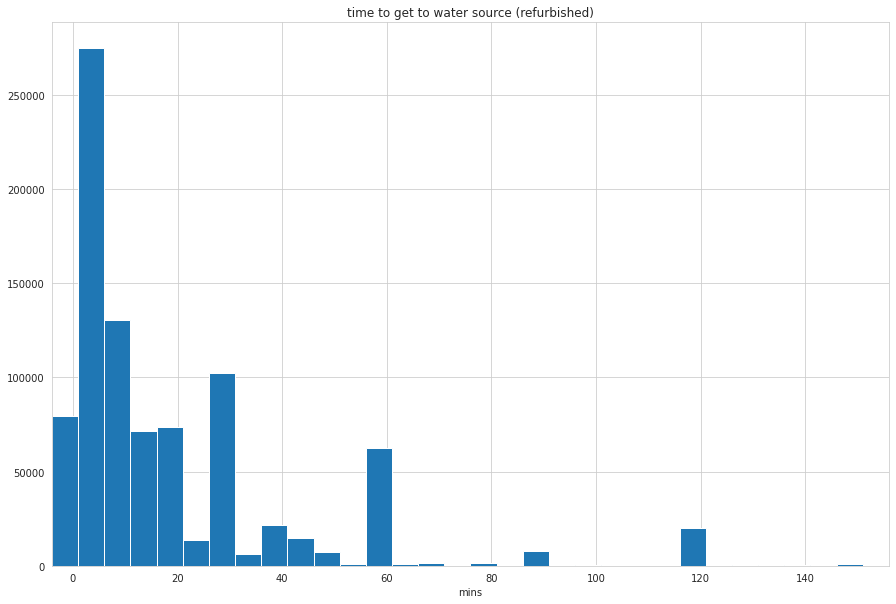

time to get to water source (refurbished)
(-4, 1000, 20)


<Figure size 432x288 with 0 Axes>

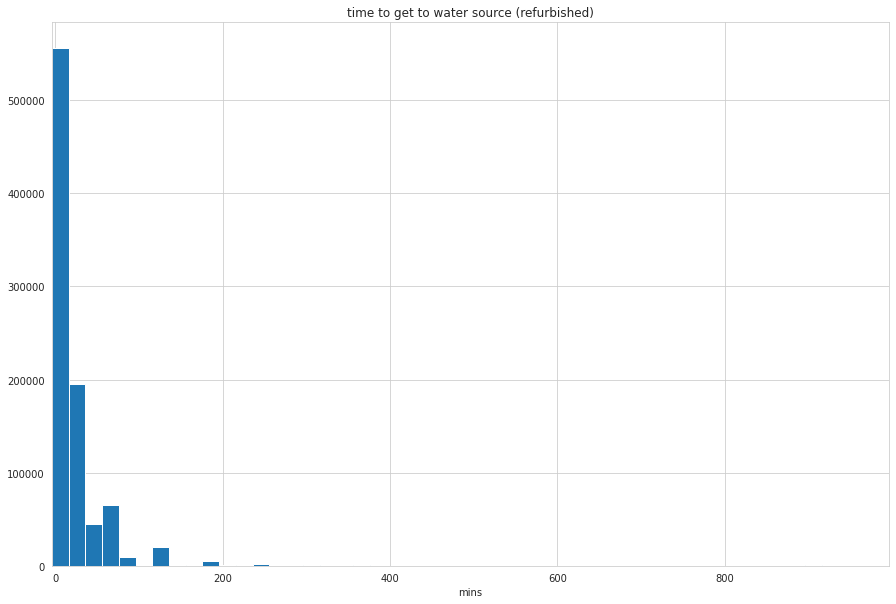

time to get to water source (refurbished)
(150, 1000, 20)


<Figure size 432x288 with 0 Axes>

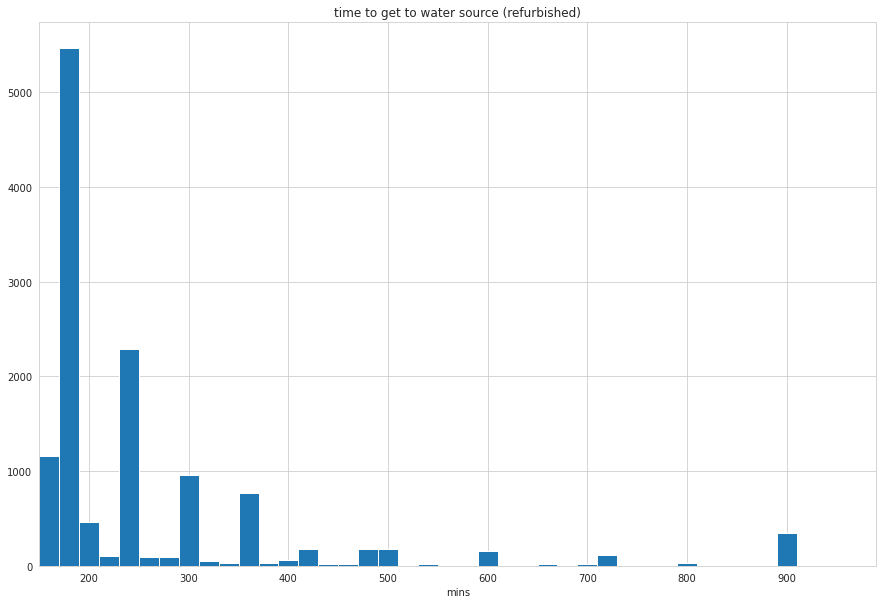

<Figure size 432x288 with 0 Axes>

In [27]:
# for col in ["time to get to water source (refurbished) + penalty (capped)", "time to get to water source (refurbished) + penalty",
#             "time to get to water source (minutes)", "time to get to water source (refurbished)"]:

for col in ["time to get to water source (minutes)", "time to get to water source (refurbished)"]:
    for bins in [(-4, 160, 5), (-4, 1000, 20), (150, 1000, 20)]:
        print(col)
        print(bins)
        sub_df = df[col]
        bins = list(range(*bins))
        # print(bins)
        #adjust the figure size
        fig, ax = plt.subplots(figsize=(15, 10))
        hist = sub_df.hist(bins=bins, ax=ax)
        ax.set_xlim([bins[0], bins[-1]])
        ax.set_title(col)
        ax.set_xlabel("mins")
        plt.show()
        plt.clf()

In [28]:
# for col in ["time to get to water source (refurbished) + penalty (capped)", "time to get to water source (refurbished) + penalty",
#             "time to get to water source (minutes)", "time to get to water source (refurbished)"]:
#     bins = list(range(0, 315, 5))
#     print(bins)
#     hist = df[col].plot.hist(bins=bins)
#     plt.xlim(0, 315)
#     plt.title(col)
#     plt.xlabel("mins")
#     plt.show()

In [29]:
#create distance categories
df['distance categories'] = np.NaN
df['distance categories num'] = np.NaN
replace_l = [-1, 0, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        df['distance categories'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             df['distance categories'])
        df['distance categories num'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                replace_l[nr + 1]), -nr, df['distance categories num'])
df['distance categories 2'] = np.NaN
df['distance categories num 2'] = np.NaN
replace_l = [-1, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        df['distance categories 2'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             df['distance categories 2'])
        df['distance categories num 2'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                replace_l[nr + 1]), -nr, df['distance categories num 2'])

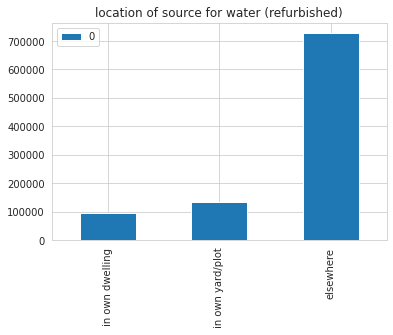

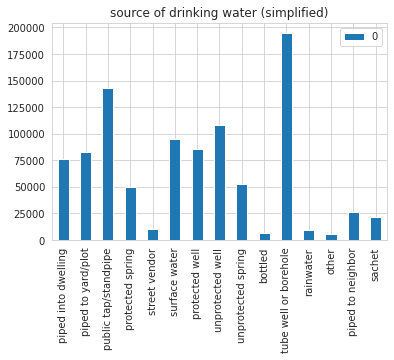

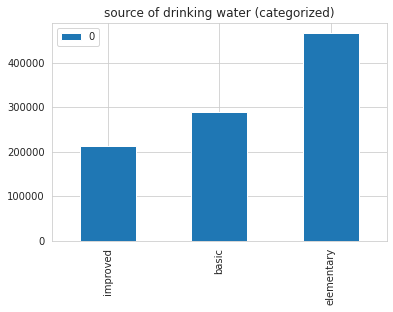

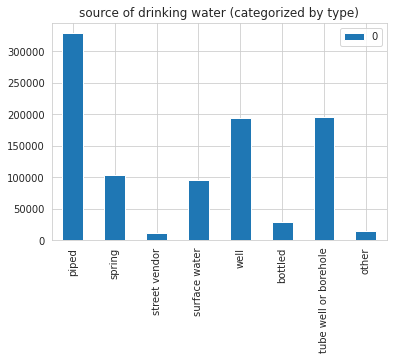

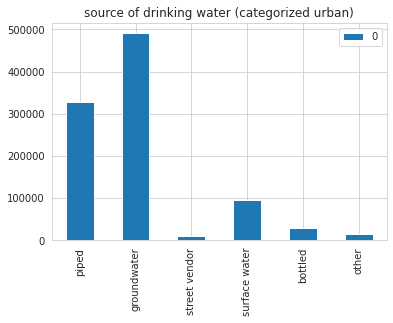

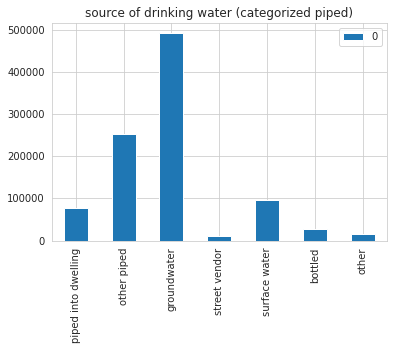

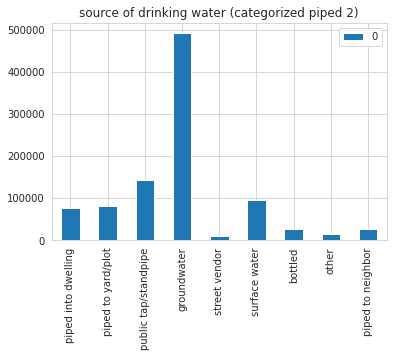

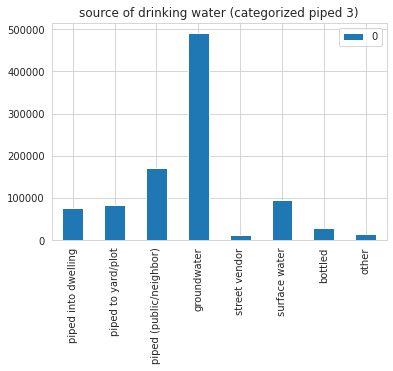

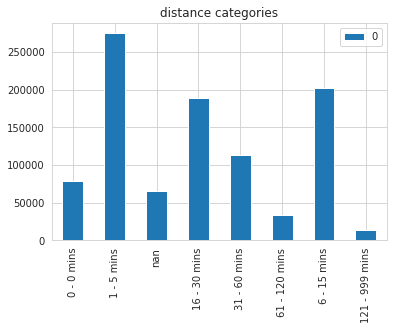

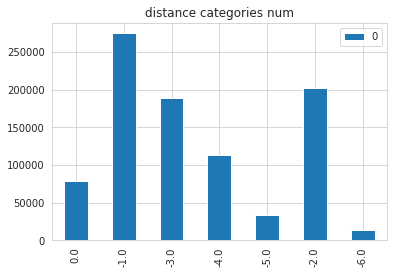

In [30]:
for col in ["location of source for water (refurbished)", "source of drinking water (simplified)",
           "source of drinking water (categorized)", "source of drinking water (categorized by type)",
           "source of drinking water (categorized urban)", "source of drinking water (categorized piped)",
           "source of drinking water (categorized piped 2)", "source of drinking water (categorized piped 3)",
           'distance categories', 'distance categories num']:
#     series = df[col].replace({np.NaN: None})
#     print(series)
    counts = Counter(df[col].dropna())
#     print(col, counts, type(counts))
    count_df = pd.DataFrame.from_dict(counts, orient='index')
    count_df.plot(kind='bar')
    plt.title(col)


In [31]:
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,URBAN_RURA,DHS survey ID,source of drinking water (simplified),source of drinking water (categorized by type),source of drinking water (categorized piped),source of drinking water (categorized piped 2),source of drinking water (categorized piped 3),source of drinking water (categorized urban),source of drinking water (categorized),source of drinking water (weights),time to get to water source (refurbished),location of source for water (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories,distance categories num,distance categories 2,distance categories num 2
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,0.0,in own dwelling,0.0,5.0,0.0,0.0,0 - 0 mins,0.0,0 - 5 mins,0.0
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,0.0,in own dwelling,0.0,5.0,0.0,0.0,0 - 0 mins,0.0,0 - 5 mins,0.0
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,0.0,in own dwelling,0.0,5.0,0.0,0.0,0 - 0 mins,0.0,0 - 5 mins,0.0
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,0.0,in own dwelling,0.0,5.0,0.0,0.0,0 - 0 mins,0.0,0 - 5 mins,0.0
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,0.0,in own dwelling,0.0,5.0,0.0,0.0,0 - 0 mins,0.0,0 - 5 mins,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970631,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,0.0,NaN,in own yard/plot,yes,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0,1.0,in own yard/plot,5.0,3.0,6.0,6.0,1 - 5 mins,-1.0,0 - 5 mins,0.0
970632,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,0.0,NaN,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0,1.0,in own yard/plot,5.0,3.0,6.0,6.0,1 - 5 mins,-1.0,0 - 5 mins,0.0
970633,400 27,ZW7,400.0,27.0,11.0,2015.0,5.0,mashonaland east,unprotected well,ZWGE72FL,0.0,10.0,elsewhere,yes,NaN,ZW201500000400,R,ZW2015,unprotected well,well,groundwater,groundwater,groundwater,groundwater,elementary,2.0,10.0,elsewhere,10.0,1.0,20.0,20.0,6 - 15 mins,-2.0,6 - 15 mins,-1.0
970634,400 28,ZW7,400.0,28.0,11.0,2015.0,8.0,mashonaland east,protected well,ZWGE72FL,0.0,NaN,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0,1.0,in own yard/plot,5.0,3.0,6.0,6.0,1 - 5 mins,-1.0,0 - 5 mins,0.0


In [32]:
#create PCA
df2 = df
for n1, col_l in zip(['cat_distance', 'min', 'w_location_weighting', 'w_penalty'], 
                     [["source of drinking water (weights)", "distance categories num"],
             ["source of drinking water (weights)", 'time to get to water source (refurbished)'],
            ["source of drinking water (weights)", 'time to get to water source (refurbished)',
             'weighting (location)'],
            ["source of drinking water (weights)", 'time to get to water source (refurbished) + penalty']]): 
    for name, ind in {'urban': 'U', 'rural': 'R', 'all': 'a'}.items():
        ges_l = ["DHSID", "cluster number", "URBAN_RURA"] + col_l
        sub_df = df[ges_l].dropna().copy()
        if name != 'all':
            sub_df = sub_df[sub_df["URBAN_RURA"] == ind]
        features = sub_df[col_l]
        col_n = 'PCA ' + n1 + ' ' + name
#         features["source of drinking water (weights)"] = -features["source of drinking water (weights)"]
#         features["distance categories num"] = -features["distance categories num"]
#         if "time to get to water source (refurbished)" in features.columns:
#             features["time to get to water source (refurbished)"] = -features["time to get to water source (refurbished)"]
#         print(name)
#         print('f', features)
        T = StandardScaler().fit_transform(features)
#         t2 = pd.DataFrame(T, columns=col_l)
#         print(t2)
        # apply the pca analysis
        pca_model = PCA(n_components=2)
        pca_model.fit(T)
        I = pca_model.transform(T)
#         print('I', I)
        sub_df[col_n] = I[:, 0]
        # print the varianz distribution of the principle components
        varianz_of_pcs = pca_model.explained_variance_ratio_
        print(name)
#         ax2 = sns.displot(sub_df[col_n], stat='probability')
#         print(sub_df)
        df2 = pd.merge(df2, sub_df[col_n], left_index=True, right_index=True, how='left')
        features['PCA'] = I[:,0]
        print(n1, name)
        corr_value = features.corr(method="pearson")
        for pc_i, pc_v in enumerate(varianz_of_pcs):
            print("Varianz of pc{}: {}".format(pc_i+1, pc_v))
#         pearson_corr = corr_value["Prediction"][1]
        print(corr_value.head())
        print('components', pca_model.components_)
        print('explained variance', pca_model.explained_variance_ratio_)
        print('singular values', pca_model.singular_values_)
        print('mean', pca_model.mean_)

        loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)

        fig = px.scatter(I, x=0, y=1)#, color=col_l)

        for i, feature in enumerate(col_l):
            fig.add_shape(
                type='line',
                x0=0, y0=0,
                x1=loadings[i, 0],
                y1=loadings[i, 1]
            )
            fig.add_annotation(
                x=loadings[i, 0],
                y=loadings[i, 1],
                ax=0, ay=0,
                xanchor="center",
                yanchor="bottom",
                text=feature,
            )
        fig.write_image(projects_p + '/imgs/pca/' + n1 + '_' + ind + '.png')
        # fig.show()
        
        
        
        
#         print('df', df)

# df2[col_l + ["PCA urban"]].dropna()
df = df2

urban


/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['PCA'] = I[:,0]


cat_distance urban
Varianz of pc1: 0.8037631785270161
Varianz of pc2: 0.19623682147298394
                                    source of drinking water (weights)  distance categories num       PCA
source of drinking water (weights)                            1.000000                 0.607526 -0.896528
distance categories num                                       0.607526                 1.000000 -0.896528
PCA                                                          -0.896528                -0.896528  1.000000
components [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
explained variance [0.80376318 0.19623682]
singular values [709.85916523 350.75057454]
mean [6.96346071e-17 1.74086518e-17]
rural


/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cat_distance rural
Varianz of pc1: 0.6778547870282299
Varianz of pc2: 0.3221452129717701
                                    source of drinking water (weights)  distance categories num       PCA
source of drinking water (weights)                            1.000000                 0.355710  0.823319
distance categories num                                       0.355710                 1.000000  0.823319
PCA                                                           0.823319                 0.823319  1.000000
components [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
explained variance [0.67785479 0.32214521]
singular values [887.77272157 612.01110679]
mean [4.98670224e-17 1.22614208e-16]
all


/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cat_distance all
Varianz of pc1: 0.7655696250611174
Varianz of pc2: 0.23443037493888275
                                    source of drinking water (weights)  distance categories num       PCA
source of drinking water (weights)                            1.000000                 0.531139 -0.874968
distance categories num                                       0.531139                 1.000000 -0.874968
PCA                                                          -0.874968                -0.874968  1.000000
components [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
explained variance [0.76556963 0.23443037]
singular values [1170.50492296  647.72079272]
mean [1.87781507e-16 5.69188872e-17]
urban


/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min urban
Varianz of pc1: 0.6296212912039199
Varianz of pc2: 0.37037870879608015
                                           source of drinking water (weights)  time to get to water source (refurbished)       PCA
source of drinking water (weights)                                   1.000000                                  -0.259243 -0.793487
time to get to water source (refurbished)                           -0.259243                                   1.000000  0.793487
PCA                                                                 -0.793487                                   0.793487  1.000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.62962129 0.37037871]
singular values [628.27220025 481.87139611]
mean [6.96346071e-17 2.17608147e-18]
rural


/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min rural
Varianz of pc1: 0.5824717066847558
Varianz of pc2: 0.4175282933152441
                                           source of drinking water (weights)  time to get to water source (refurbished)       PCA
source of drinking water (weights)                                   1.000000                                  -0.164943 -0.763198
time to get to water source (refurbished)                           -0.164943                                   1.000000  0.763198
PCA                                                                 -0.763198                                   0.763198  1.000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.58247171 0.41752829]
singular values [822.94513087 696.74910232]
mean [4.98670224e-17 4.03825103e-17]
all


/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min all
Varianz of pc1: 0.6264229743136497
Varianz of pc2: 0.3735770256863504
                                           source of drinking water (weights)  time to get to water source (refurbished)       PCA
source of drinking water (weights)                                   1.000000                                  -0.252846 -0.791469
time to get to water source (refurbished)                           -0.252846                                   1.000000  0.791469
PCA                                                                 -0.791469                                   0.791469  1.000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.62642297 0.37357703]
singular values [1058.80195928  817.65665839]
mean [1.87781507e-16 1.01164428e-17]
urban


/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_location_weighting urban
Varianz of pc1: 0.6147882733386468
Varianz of pc2: 0.27545382531617113
                                           source of drinking water (weights)  time to get to water source (refurbished)  weighting (location)       PCA
source of drinking water (weights)                                   1.000000                                  -0.259395              0.670238 -0.870002
time to get to water source (refurbished)                           -0.259395                                   1.000000             -0.282814  0.561581
weighting (location)                                                 0.670238                                  -0.282814              1.000000 -0.878685
PCA                                                                 -0.870002                                   0.561581             -0.878685  1.000000
components [[-0.64061489  0.41351252 -0.64700846]
 [ 0.31381114  0.91002048  0.2708972 ]]
explained variance [0.61478827 0.27545383]
sing

/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_location_weighting rural
Varianz of pc1: 0.5471705084767352
Varianz of pc2: 0.29349476686340115
                                           source of drinking water (weights)  time to get to water source (refurbished)  weighting (location)       PCA
source of drinking water (weights)                                   1.000000                                  -0.164985              0.516516 -0.812837
time to get to water source (refurbished)                           -0.164985                                   1.000000             -0.234822  0.518016
weighting (location)                                                 0.516516                                  -0.234822              1.000000 -0.844077
PCA                                                                 -0.812837                                   0.518016             -0.844077  1.000000
components [[-0.63442694  0.40431659 -0.65880995]
 [ 0.36522647  0.90795169  0.20550754]]
explained variance [0.54717051 0.29349477]
sing

/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_location_weighting all
Varianz of pc1: 0.6084716143869532
Varianz of pc2: 0.27499175404094006
                                           source of drinking water (weights)  time to get to water source (refurbished)  weighting (location)       PCA
source of drinking water (weights)                                   1.000000                                  -0.252987              0.649380 -0.860948
time to get to water source (refurbished)                           -0.252987                                   1.000000             -0.285969  0.566547
weighting (location)                                                 0.649380                                  -0.285969              1.000000 -0.873618
PCA                                                                 -0.860948                                   0.566547             -0.873618  1.000000
components [[-0.63722987  0.41932892 -0.64660757]
 [ 0.32793655  0.90680345  0.264887  ]]
explained variance [0.60847161 0.27499175]
singul

/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_penalty urban
Varianz of pc1: 0.6623333868779014
Varianz of pc2: 0.3376666131220986
                                                    source of drinking water (weights)  time to get to water source (refurbished) + penalty       PCA
source of drinking water (weights)                                            1.000000                                          -0.324667   -0.813839
time to get to water source (refurbished) + pen...                           -0.324667                                           1.000000    0.813839
PCA                                                                          -0.813839                                           0.813839    1.000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.66233339 0.33766661]
singular values [644.24879942 460.00161353]
mean [ 7.69210944e-17 -2.97524988e-17]
rural


/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_penalty rural
Varianz of pc1: 0.5960283550814588
Varianz of pc2: 0.40397164491854115
                                                    source of drinking water (weights)  time to get to water source (refurbished) + penalty       PCA
source of drinking water (weights)                                            1.000000                                          -0.192057   -0.772029
time to get to water source (refurbished) + pen...                           -0.192057                                           1.000000    0.772029
PCA                                                                          -0.772029                                           0.772029    1.000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.59602836 0.40397164]
singular values [832.15314429 685.08623139]
mean [-1.79363081e-16 -1.57542041e-17]
all


/tmp/ipykernel_544215/2083121222.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_penalty all
Varianz of pc1: 0.648564097391618
Varianz of pc2: 0.35143590260838187
                                                    source of drinking water (weights)  time to get to water source (refurbished) + penalty       PCA
source of drinking water (weights)                                            1.000000                                          -0.297128   -0.805335
time to get to water source (refurbished) + pen...                           -0.297128                                           1.000000    0.805335
PCA                                                                          -0.805335                                           0.805335    1.000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.6485641 0.3514359]
singular values [1077.00692519  792.80267602]
mean [ 6.24219866e-17 -3.66459015e-17]


PCA cat_distance urban : -0.8965284036364797
PCA cat_distance urban -4.107687257359954 3.77187455075976e-17 1.8611298101796991


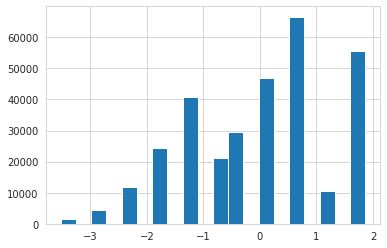

PCA cat_distance rural : 0.823319371221326
PCA cat_distance rural -2.8954212165167954 5.133369955383807e-18 3.375969316148006


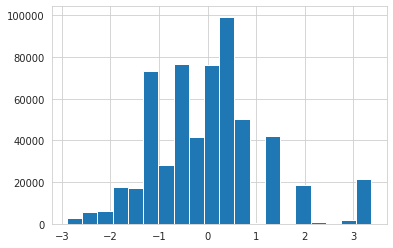

PCA cat_distance all : -0.874968356605633
PCA cat_distance all -3.0549124896795443 8.207500253479385e-17 2.54811141045472


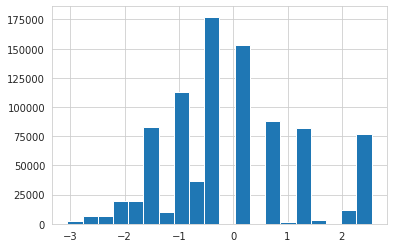

PCA min urban : -0.7934867933392967
PCA min urban -19.959681080967677 -1.3419169074818377e-17 1.251978321952111


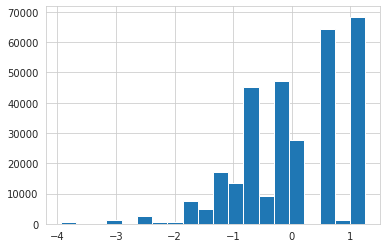

PCA min rural : -0.7631983403315101
PCA min rural -15.009542816185023 4.194696592113625e-17 2.503318717817879


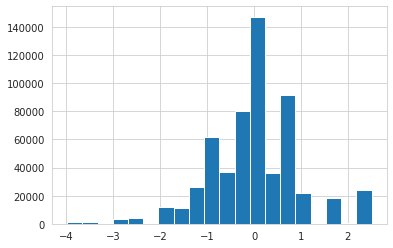

PCA min all : -0.7914688713484517
PCA min all -15.9935253378215 -4.8279413255761086e-18 1.8380299191989626


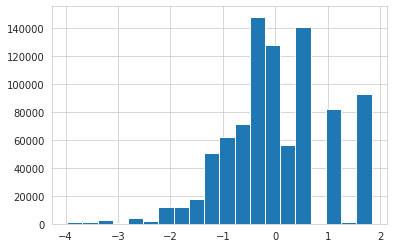

PCA w_location_weighting urban : -0.870002392453845
PCA w_location_weighting urban -12.68839408118124 -3.1929510895902425e-17 2.1464807392984158


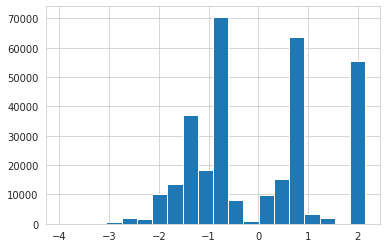

PCA w_location_weighting rural : -0.8128372263208761
PCA w_location_weighting rural -9.166555287350938 -4.131809109136543e-17 4.420348231463896


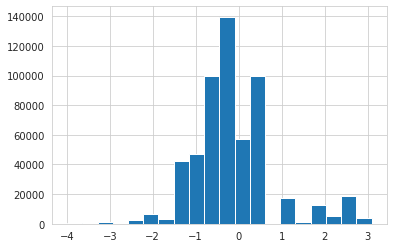

PCA w_location_weighting all : -0.8609479915035964
PCA w_location_weighting all -10.165618955920614 -2.949470651213871e-17 3.136696738942439


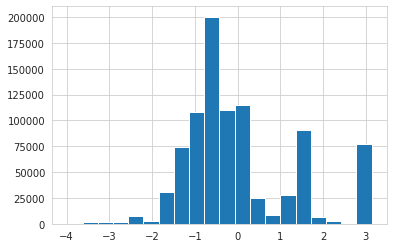

PCA w_penalty urban : -0.8138386737418449
PCA w_penalty urban -19.331393385123658 -4.1363230024237233e-17 1.3759953083049832


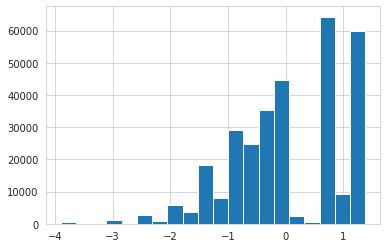

PCA w_penalty rural : -0.7720287268498756
PCA w_penalty rural -14.811754797502262 -4.305496762628962e-18 2.6387863220053696


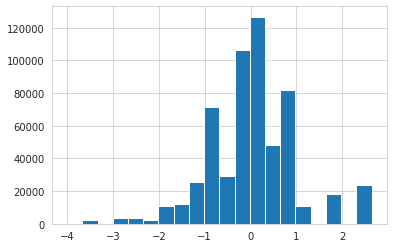

PCA w_penalty all : -0.8053347734896441
PCA w_penalty all -15.646748539076842 -2.7587721177302156e-17 1.9640040288017566


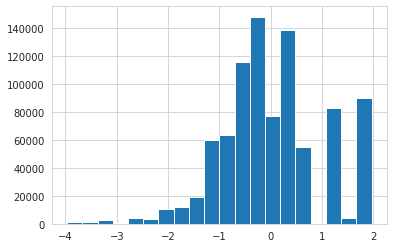

<Figure size 432x288 with 0 Axes>

In [33]:
for col in df.columns:
    if "PCA" in col:
        r2 = df[[col, "source of drinking water (weights)"]].corr().iloc[1,0]
        print(col, ':', r2)
        if r2 < 0:
            df[col] = df[col] * (-1)
        sub_df = df[col]
        #drop values <-4 and >4 for sub df
        sub_df = sub_df[(sub_df > -4) & (sub_df < 4)]
        sub_df.hist(bins=20)
        print(col, df[col].min(), df[col].mean(), df[col].max())
        plt.show()
        plt.clf()

In [34]:
#NaN error
df2 = df[["PCA w_location_weighting urban", 'water shortages']].dropna()
print(scipy.stats.pointbiserialr(df2["PCA w_location_weighting urban"], df2['water shortages']))

PointbiserialrResult(correlation=0.039698097678052546, pvalue=4.596346197804321e-29)


In [35]:
cluster_df = df.groupby('DHSID').mean()
cluster_df

,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all
DHSID,,,,,,,,,,,,,,,,,,,,,,,,,,,
AO201100000001,1.0,18.722222,2.972222,2011.0,5.750000,NaN,NaN,4.861111,0.138889,0.694444,4.722222,0.833333,0.833333,-0.138889,0.000000,1.694375,NaN,2.389082,1.163322,NaN,1.747679,1.953253,NaN,2.920635,1.273534,NaN,1.862227
AO201100000002,2.0,20.343750,3.000000,2011.0,5.812500,NaN,NaN,4.593750,0.354839,2.031250,4.187500,2.129032,2.129032,-0.354839,0.000000,1.435097,NaN,2.141816,1.025475,NaN,1.607198,1.652815,NaN,2.584693,1.114223,NaN,1.703980
AO201100000003,3.0,19.194444,2.000000,2011.0,5.361111,NaN,NaN,3.083333,1.000000,9.583333,1.166667,6.000000,6.000000,-1.000000,0.000000,0.660492,NaN,1.403097,0.613650,NaN,1.187503,0.755241,NaN,1.581049,0.638273,NaN,1.231209
AO201100000004,4.0,19.314286,2.000000,2011.0,4.857143,NaN,NaN,3.057143,1.000000,9.714286,1.114286,6.000000,6.000000,-1.000000,0.000000,0.660492,NaN,1.403097,0.613650,NaN,1.187503,0.755241,NaN,1.581049,0.638273,NaN,1.231209
AO201100000005,5.0,19.000000,2.486486,2011.0,5.459459,NaN,NaN,3.810811,0.965517,5.945946,2.621622,5.793103,5.793103,-0.965517,0.000000,0.701893,NaN,1.442581,0.635661,NaN,1.209935,0.803215,NaN,1.634692,0.663712,NaN,1.256478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW201500000396,396.0,14.750000,9.541667,2015.0,3.541667,0.250000,13.071429,2.750000,8.041667,7.916667,1.833333,15.958333,15.958333,-1.416667,-0.416667,-0.354361,NaN,0.398066,-0.304867,NaN,0.275902,-0.507890,NaN,0.227977,-0.333147,NaN,0.274485
ZW201500000397,397.0,14.200000,10.000000,2015.0,3.920000,0.200000,17.500000,2.920000,4.960000,6.200000,2.520000,11.160000,11.160000,-1.320000,-0.320000,NaN,1.070172,0.555210,NaN,0.818591,0.435981,NaN,1.340857,0.690740,NaN,0.857838,0.461661
ZW201500000398,398.0,15.285714,9.000000,2015.0,4.714286,0.142857,27.037037,1.892857,26.107143,9.821429,1.071429,35.928571,35.928571,-2.714286,-1.714286,NaN,-0.462516,-0.808671,NaN,-0.313061,-0.574186,NaN,-0.495110,-0.814670,NaN,-0.325610,-0.599291


In [36]:
cluster_dfb = pd.merge(cluster_df, locations_df, how="left", on="DHSID")
cluster_dfb[cluster_dfb["LATNUM"].notna()]

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name
0,AO201100000001,1.0,18.722222,2.972222,2011.0,5.750000,NaN,NaN,4.861111,0.138889,0.694444,4.722222,0.833333,0.833333,-0.138889,0.000000,1.694375,NaN,2.389082,1.163322,NaN,1.747679,1.953253,NaN,2.920635,1.273534,NaN,1.862227,Angola,2011.0,U,-12.350257,13.534922,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000001.tif
1,AO201100000002,2.0,20.343750,3.000000,2011.0,5.812500,NaN,NaN,4.593750,0.354839,2.031250,4.187500,2.129032,2.129032,-0.354839,0.000000,1.435097,NaN,2.141816,1.025475,NaN,1.607198,1.652815,NaN,2.584693,1.114223,NaN,1.703980,Angola,2011.0,U,-12.360865,13.551494,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000002.tif
2,AO201100000003,3.0,19.194444,2.000000,2011.0,5.361111,NaN,NaN,3.083333,1.000000,9.583333,1.166667,6.000000,6.000000,-1.000000,0.000000,0.660492,NaN,1.403097,0.613650,NaN,1.187503,0.755241,NaN,1.581049,0.638273,NaN,1.231209,Angola,2011.0,U,-12.613421,13.413085,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000003.tif
3,AO201100000004,4.0,19.314286,2.000000,2011.0,4.857143,NaN,NaN,3.057143,1.000000,9.714286,1.114286,6.000000,6.000000,-1.000000,0.000000,0.660492,NaN,1.403097,0.613650,NaN,1.187503,0.755241,NaN,1.581049,0.638273,NaN,1.231209,Angola,2011.0,U,-12.581454,13.397711,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000004.tif
4,AO201100000005,5.0,19.000000,2.486486,2011.0,5.459459,NaN,NaN,3.810811,0.965517,5.945946,2.621622,5.793103,5.793103,-0.965517,0.000000,0.701893,NaN,1.442581,0.635661,NaN,1.209935,0.803215,NaN,1.634692,0.663712,NaN,1.256478,Angola,2011.0,U,-12.578135,13.418748,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000005.tif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38709,ZW201500000396,396.0,14.750000,9.541667,2015.0,3.541667,0.250000,13.071429,2.750000,8.041667,7.916667,1.833333,15.958333,15.958333,-1.416667,-0.416667,-0.354361,NaN,0.398066,-0.304867,NaN,0.275902,-0.507890,NaN,0.227977,-0.333147,NaN,0.274485,Zimbabwe,2015.0,U,-17.915288,31.156115,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000396.tif
38710,ZW201500000397,397.0,14.200000,10.000000,2015.0,3.920000,0.200000,17.500000,2.920000,4.960000,6.200000,2.520000,11.160000,11.160000,-1.320000,-0.320000,NaN,1.070172,0.555210,NaN,0.818591,0.435981,NaN,1.340857,0.690740,NaN,0.857838,0.461661,Zimbabwe,2015.0,R,-18.379501,31.872287,Zimbabwe,Manicaland,Makoni,ZWGE72FL,ZWGE72FL00000397.tif
38711,ZW201500000398,398.0,15.285714,9.000000,2015.0,4.714286,0.142857,27.037037,1.892857,26.107143,9.821429,1.071429,35.928571,35.928571,-2.714286,-1.714286,NaN,-0.462516,-0.808671,NaN,-0.313061,-0.574186,NaN,-0.495110,-0.814670,NaN,-0.325610,-0.599291,Zimbabwe,2015.0,R,-16.660612,29.850649,Zimbabwe,Mashonaland West,Hurungwe,ZWGE72FL,ZWGE72FL00000398.tif
38712,ZW201500000399,399.0,15.240000,7.000000,2015.0,4.360000,0.280000,13.500000,2.720000,8.040000,7.800000,1.880000,15.840000,15.840000,-1.400000,-0.520000,-0.363167,NaN,0.387585,-0.323357,NaN,0.256924,-0.505526,NaN,0.233614,-0.349300,NaN,0.257444,Zimbabwe,2015.0,U,-17.914251,30.956975,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000399.tif


In [37]:
cols = [c for c in df.columns if "PCA w_lo" in c or "(weights)" in c] + ["time to get to water source (refurbished)", "weighting (location)"]
print(cols)
corr_df = df[cols]

# create a correlation matrix
corr_matrix = corr_df.corr()

# print the correlation matrix
print(corr_matrix)

['source of drinking water (weights)', 'PCA w_location_weighting urban', 'PCA w_location_weighting rural', 'PCA w_location_weighting all', 'time to get to water source (refurbished)', 'weighting (location)']
                                           source of drinking water (weights)  PCA w_location_weighting urban  PCA w_location_weighting rural  PCA w_location_weighting all  time to get to water source (refurbished)  weighting (location)
source of drinking water (weights)                                   1.000000                        0.870002                        0.812837                      0.860948                                  -0.252266              0.627067
PCA w_location_weighting urban                                       0.870002                        1.000000                             NaN                      0.997411                                  -0.561581              0.878685
PCA w_location_weighting rural                                       0.812837    

In [38]:
# cluster_dfc1 = df.groupby('DHSID').mean()
# cluster_dfc2 = pd.merge(cluster_dfc1, locations_df, how="left", left_on="alt_DHSID", right_on="DHSID")
# cluster_dfc2

In [39]:
join_df = pd.DataFrame(df[["DHSID"]].value_counts(dropna=False)).reset_index()
join_df.rename(columns={0: "households"}, inplace=True)
join_df

,DHSID,households
0,EG201408400151,108
1,EG201408400116,87
2,EG201401470110,71
3,EG201401820401,62
4,EG201400451412,61
...,...,...
38709,EG201401051401,1
38710,ZA201700000529,1
38711,ZA201700000211,1
38712,EG201401182601,1


In [40]:
cluster_df2 = pd.merge(cluster_dfb, join_df, on="DHSID")
cluster_df2

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households
0,AO201100000001,1.0,18.722222,2.972222,2011.0,5.750000,NaN,NaN,4.861111,0.138889,0.694444,4.722222,0.833333,0.833333,-0.138889,0.000000,1.694375,NaN,2.389082,1.163322,NaN,1.747679,1.953253,NaN,2.920635,1.273534,NaN,1.862227,Angola,2011.0,U,-12.350257,13.534922,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000001.tif,36
1,AO201100000002,2.0,20.343750,3.000000,2011.0,5.812500,NaN,NaN,4.593750,0.354839,2.031250,4.187500,2.129032,2.129032,-0.354839,0.000000,1.435097,NaN,2.141816,1.025475,NaN,1.607198,1.652815,NaN,2.584693,1.114223,NaN,1.703980,Angola,2011.0,U,-12.360865,13.551494,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000002.tif,32
2,AO201100000003,3.0,19.194444,2.000000,2011.0,5.361111,NaN,NaN,3.083333,1.000000,9.583333,1.166667,6.000000,6.000000,-1.000000,0.000000,0.660492,NaN,1.403097,0.613650,NaN,1.187503,0.755241,NaN,1.581049,0.638273,NaN,1.231209,Angola,2011.0,U,-12.613421,13.413085,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000003.tif,36
3,AO201100000004,4.0,19.314286,2.000000,2011.0,4.857143,NaN,NaN,3.057143,1.000000,9.714286,1.114286,6.000000,6.000000,-1.000000,0.000000,0.660492,NaN,1.403097,0.613650,NaN,1.187503,0.755241,NaN,1.581049,0.638273,NaN,1.231209,Angola,2011.0,U,-12.581454,13.397711,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000004.tif,35
4,AO201100000005,5.0,19.000000,2.486486,2011.0,5.459459,NaN,NaN,3.810811,0.965517,5.945946,2.621622,5.793103,5.793103,-0.965517,0.000000,0.701893,NaN,1.442581,0.635661,NaN,1.209935,0.803215,NaN,1.634692,0.663712,NaN,1.256478,Angola,2011.0,U,-12.578135,13.418748,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000005.tif,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38709,ZW201500000396,396.0,14.750000,9.541667,2015.0,3.541667,0.250000,13.071429,2.750000,8.041667,7.916667,1.833333,15.958333,15.958333,-1.416667,-0.416667,-0.354361,NaN,0.398066,-0.304867,NaN,0.275902,-0.507890,NaN,0.227977,-0.333147,NaN,0.274485,Zimbabwe,2015.0,U,-17.915288,31.156115,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000396.tif,24
38710,ZW201500000397,397.0,14.200000,10.000000,2015.0,3.920000,0.200000,17.500000,2.920000,4.960000,6.200000,2.520000,11.160000,11.160000,-1.320000,-0.320000,NaN,1.070172,0.555210,NaN,0.818591,0.435981,NaN,1.340857,0.690740,NaN,0.857838,0.461661,Zimbabwe,2015.0,R,-18.379501,31.872287,Zimbabwe,Manicaland,Makoni,ZWGE72FL,ZWGE72FL00000397.tif,25
38711,ZW201500000398,398.0,15.285714,9.000000,2015.0,4.714286,0.142857,27.037037,1.892857,26.107143,9.821429,1.071429,35.928571,35.928571,-2.714286,-1.714286,NaN,-0.462516,-0.808671,NaN,-0.313061,-0.574186,NaN,-0.495110,-0.814670,NaN,-0.325610,-0.599291,Zimbabwe,2015.0,R,-16.660612,29.850649,Zimbabwe,Mashonaland West,Hurungwe,ZWGE72FL,ZWGE72FL00000398.tif,28
38712,ZW201500000399,399.0,15.240000,7.000000,2015.0,4.360000,0.280000,13.500000,2.720000,8.040000,7.800000,1.880000,15.840000,15.840000,-1.400000,-0.520000,-0.363167,NaN,0.387585,-0.323357,NaN,0.256924,-0.505526,NaN,0.233614,-0.349300,NaN,0.257444,Zimbabwe,2015.0,U,-17.914251,30.956975,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000399.tif,25


In [41]:
#Create Stds
stddev_df = df.groupby('DHSID').std()
stddev_df = stddev_df.drop(columns=
                           ["cluster number", "household number", "year of interview", "number of household members"])
replace_d = {c: 'Std Deviation: '+ c for c in stddev_df.columns}
stddev_df.rename(columns=replace_d)
stddev_df = df.groupby('DHSID').std()
stddev_df = stddev_df.drop(columns=
                           ["cluster number", "household number", "year of interview", "number of household members"])
replace_d = {c: 'Std Deviation: '+ c for c in stddev_df.columns}
stddev_df =stddev_df.rename(columns=replace_d)
stddev_df

,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all
DHSID,,,,,,,,,,,,,,,,,,,,,,,
AO201100000001,0.166667,NaN,NaN,0.350736,0.350736,1.753681,0.701472,2.104417,2.104417,0.350736,0.000000,0.421107,NaN,0.401598,0.223885,NaN,0.228163,0.487958,NaN,0.545622,0.258746,NaN,0.257018
AO201100000002,0.000000,NaN,NaN,0.559918,0.486373,2.799590,1.119836,2.918241,2.918241,0.486373,0.000000,0.583958,NaN,0.556904,0.310466,NaN,0.316399,0.676662,NaN,0.756626,0.358808,NaN,0.356412
AO201100000003,0.000000,NaN,NaN,0.280306,0.000000,1.401530,0.560612,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000
AO201100000004,0.000000,NaN,NaN,0.235504,0.000000,1.177521,0.471008,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000
AO201100000005,0.506712,NaN,NaN,0.461750,0.185695,2.308751,0.923500,1.114172,1.114172,0.185695,0.000000,0.222953,NaN,0.212624,0.118535,NaN,0.120800,0.258347,NaN,0.288877,0.136992,NaN,0.136077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW201500000396,0.508977,0.442326,17.560727,0.442326,14.534753,2.518051,1.007220,15.754859,15.754859,0.928611,0.928611,0.619263,NaN,0.564103,0.423502,NaN,0.388024,0.592401,NaN,0.645295,0.435462,NaN,0.399540
ZW201500000397,0.000000,0.408248,9.874209,0.640312,8.487638,2.179449,0.871780,10.399038,10.399038,0.627163,0.627163,NaN,0.659953,0.575489,NaN,0.541947,0.460828,NaN,0.847971,0.684046,NaN,0.556097,0.476571
ZW201500000398,0.000000,0.356348,22.670688,0.628890,22.784562,0.944911,0.377964,23.007130,23.007130,1.117442,1.117442,NaN,0.874638,0.791203,NaN,0.685819,0.630080,NaN,0.662596,0.571462,NaN,0.687139,0.627942


In [42]:
cluster_df5 = pd.merge(cluster_df2, stddev_df, how="left", on=['DHSID'])
cluster_df5

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all
0,AO201100000001,1.0,18.722222,2.972222,2011.0,5.750000,NaN,NaN,4.861111,0.138889,0.694444,4.722222,0.833333,0.833333,-0.138889,0.000000,1.694375,NaN,2.389082,1.163322,NaN,1.747679,1.953253,NaN,2.920635,1.273534,NaN,1.862227,Angola,2011.0,U,-12.350257,13.534922,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000001.tif,36,0.166667,NaN,NaN,0.350736,0.350736,1.753681,0.701472,2.104417,2.104417,0.350736,0.000000,0.421107,NaN,0.401598,0.223885,NaN,0.228163,0.487958,NaN,0.545622,0.258746,NaN,0.257018
1,AO201100000002,2.0,20.343750,3.000000,2011.0,5.812500,NaN,NaN,4.593750,0.354839,2.031250,4.187500,2.129032,2.129032,-0.354839,0.000000,1.435097,NaN,2.141816,1.025475,NaN,1.607198,1.652815,NaN,2.584693,1.114223,NaN,1.703980,Angola,2011.0,U,-12.360865,13.551494,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000002.tif,32,0.000000,NaN,NaN,0.559918,0.486373,2.799590,1.119836,2.918241,2.918241,0.486373,0.000000,0.583958,NaN,0.556904,0.310466,NaN,0.316399,0.676662,NaN,0.756626,0.358808,NaN,0.356412
2,AO201100000003,3.0,19.194444,2.000000,2011.0,5.361111,NaN,NaN,3.083333,1.000000,9.583333,1.166667,6.000000,6.000000,-1.000000,0.000000,0.660492,NaN,1.403097,0.613650,NaN,1.187503,0.755241,NaN,1.581049,0.638273,NaN,1.231209,Angola,2011.0,U,-12.613421,13.413085,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000003.tif,36,0.000000,NaN,NaN,0.280306,0.000000,1.401530,0.560612,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000
3,AO201100000004,4.0,19.314286,2.000000,2011.0,4.857143,NaN,NaN,3.057143,1.000000,9.714286,1.114286,6.000000,6.000000,-1.000000,0.000000,0.660492,NaN,1.403097,0.613650,NaN,1.187503,0.755241,NaN,1.581049,0.638273,NaN,1.231209,Angola,2011.0,U,-12.581454,13.397711,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000004.tif,35,0.000000,NaN,NaN,0.235504,0.000000,1.177521,0.471008,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000
4,AO201100000005,5.0,19.000000,2.486486,2011.0,5.459459,NaN,NaN,3.810811,0.965517,5.945946,2.621622,5.793103,5.793103,-0.965517,0.000000,0.701893,NaN,1.442581,0.635661,NaN,1.209935,0.803215,NaN,1.634692,0.663712,NaN,1.256478,Angola,2011.0,U,-12.578135,13.418748,Angola,Be

In [43]:
for col in ["source of drinking water (simplified)", "source of drinking water (categorized by type)", 
            "source of drinking water (categorized urban)", "source of drinking water (categorized piped)",
            "source of drinking water (categorized piped 2)", "source of drinking water (categorized piped 3)",
            "source of drinking water (categorized)", "source of drinking water (weights)", 
            "location of source for water (refurbished)"]:
    count_df = pd.DataFrame(df.groupby("DHSID")[col].value_counts())
    count_df.columns = [col + ': counts']
    count_df = count_df.reset_index()
    count_df2 = count_df.pivot(index='DHSID', columns=col, 
                         values=col + ': counts')
    count_df2 = count_df2.fillna(0)
    count_df2 = count_df2.rename(columns={c: col + ': ' + str(c) for c in count_df2.columns})
    # count_df2 = count_df2.reset_index()
    # count_df
    cluster_df5 = pd.merge(cluster_df5, count_df2, how="outer", on=['DHSID'])

In [44]:
cluster_df5

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwel

source of drinking water (simplified):
asd source of drinking water (simplified): max    8126
Name: source of drinking water (simplified): tube well or borehole, dtype: int64
asd source of drinking water (simplified): max    6192
Name: source of drinking water (simplified): public tap/standpipe, dtype: int64
asd source of drinking water (simplified): max    4063
Name: source of drinking water (simplified): unprotected well, dtype: int64
asd source of drinking water (simplified): max    3893
Name: source of drinking water (simplified): piped into dwelling, dtype: int64
asd source of drinking water (simplified): max    3704
Name: source of drinking water (simplified): surface water, dtype: int64
asd source of drinking water (simplified): max    3631
Name: source of drinking water (simplified): piped to yard/plot, dtype: int64
asd source of drinking water (simplified): max    2975
Name: source of drinking water (simplified): protected well, dtype: int64
asd source of drinking water (simpl

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



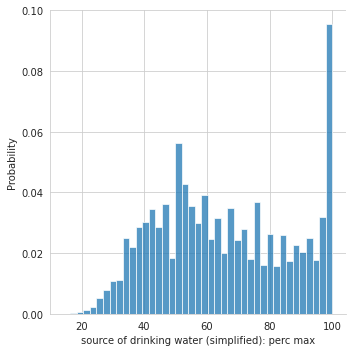

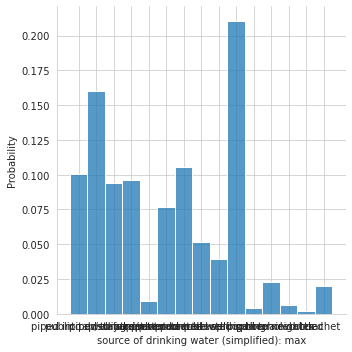

source of drinking water (categorized by type):
asd source of drinking water (categorized by type): max    15198
Name: source of drinking water (categorized by type): piped, dtype: int64
asd source of drinking water (categorized by type): max    7563
Name: source of drinking water (categorized by type): tube well or borehole, dtype: int64
asd source of drinking water (categorized by type): max    7311
Name: source of drinking water (categorized by type): well, dtype: int64
asd source of drinking water (categorized by type): max    3690
Name: source of drinking water (categorized by type): spring, dtype: int64
asd source of drinking water (categorized by type): max    3408
Name: source of drinking water (categorized by type): surface water, dtype: int64
asd source of drinking water (categorized by type): max    763
Name: source of drinking water (categorized by type): bottled, dtype: int64
asd source of drinking water (categorized by type): max    362
Name: source of drinking water (cat

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



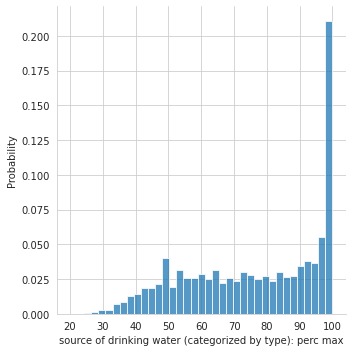

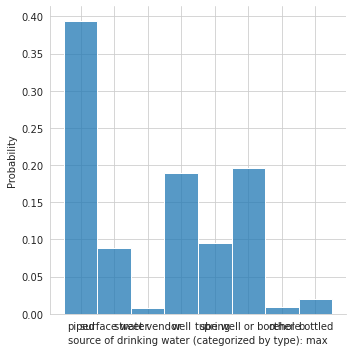

source of drinking water (categorized urban):
asd source of drinking water (categorized urban): max    19952
Name: source of drinking water (categorized urban): groundwater, dtype: int64
asd source of drinking water (categorized urban): max    14434
Name: source of drinking water (categorized urban): piped, dtype: int64
asd source of drinking water (categorized urban): max    2910
Name: source of drinking water (categorized urban): surface water, dtype: int64
asd source of drinking water (categorized urban): max    717
Name: source of drinking water (categorized urban): bottled, dtype: int64
asd source of drinking water (categorized urban): max    303
Name: source of drinking water (categorized urban): other, dtype: int64
asd source of drinking water (categorized urban): max    289
Name: source of drinking water (categorized urban): street vendor, dtype: int64
{'source of drinking water (categorized urban): max': {'source of drinking water (categorized urban): groundwater': 'groundwate

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



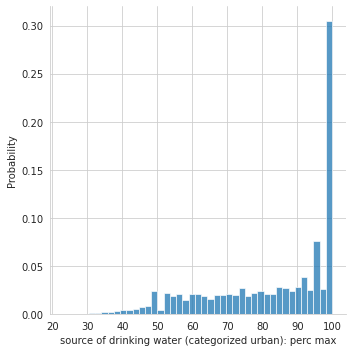

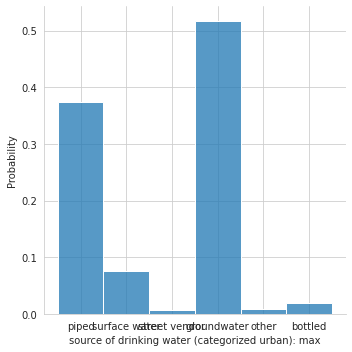

source of drinking water (categorized):
asd source of drinking water (categorized): max    18245
Name: source of drinking water (categorized): elementary, dtype: int64
asd source of drinking water (categorized): max    10825
Name: source of drinking water (categorized): basic, dtype: int64
asd source of drinking water (categorized): max    9535
Name: source of drinking water (categorized): improved, dtype: int64
{'source of drinking water (categorized): max': {'source of drinking water (categorized): elementary': 'elementary', 'source of drinking water (categorized): basic': 'basic', 'source of drinking water (categorized): improved': 'improved'}}


/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



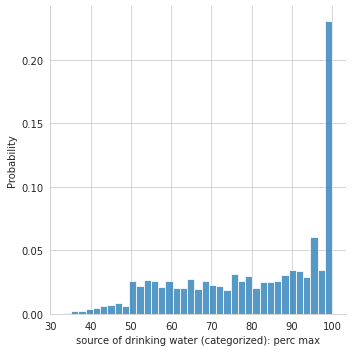

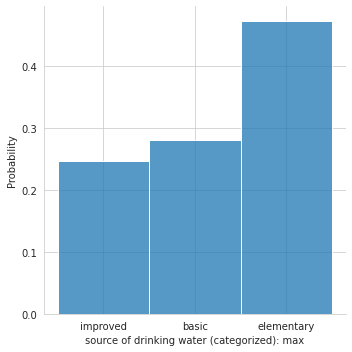

source of drinking water (weights):
asd source of drinking water (weights): max    14849
Name: source of drinking water (weights): 2.0, dtype: int64
asd source of drinking water (weights): max    12250
Name: source of drinking water (weights): 3.0, dtype: int64
asd source of drinking water (weights): max    4474
Name: source of drinking water (weights): 5.0, dtype: int64
asd source of drinking water (weights): max    3840
Name: source of drinking water (weights): 1.0, dtype: int64
asd source of drinking water (weights): max    3192
Name: source of drinking water (weights): 4.0, dtype: int64
{'source of drinking water (weights): max': {'source of drinking water (weights): 2.0': '2.0', 'source of drinking water (weights): 3.0': '3.0', 'source of drinking water (weights): 5.0': '5.0', 'source of drinking water (weights): 1.0': '1.0', 'source of drinking water (weights): 4.0': '4.0'}}


/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



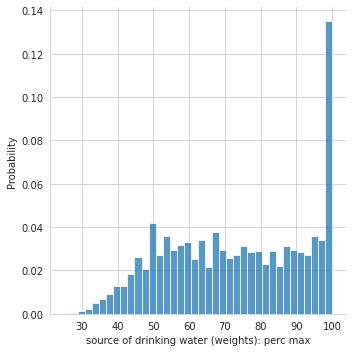

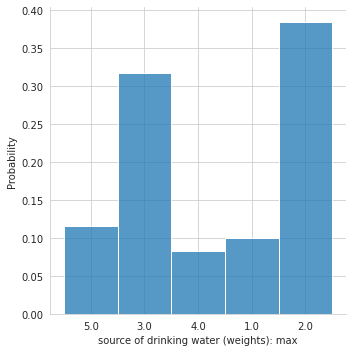

location of source for water (refurbished):
asd location of source for water (refurbished): max    30683
Name: location of source for water (refurbished): elsewhere, dtype: int64
asd location of source for water (refurbished): max    3977
Name: location of source for water (refurbished): in own yard/plot, dtype: int64
asd location of source for water (refurbished): max    3866
Name: location of source for water (refurbished): in own dwelling, dtype: int64
{'location of source for water (refurbished): max': {'location of source for water (refurbished): elsewhere': 'elsewhere', 'location of source for water (refurbished): in own yard/plot': 'in own yard/plot', 'location of source for water (refurbished): in own dwelling': 'in own dwelling'}}


/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



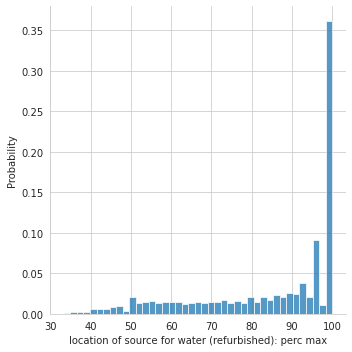

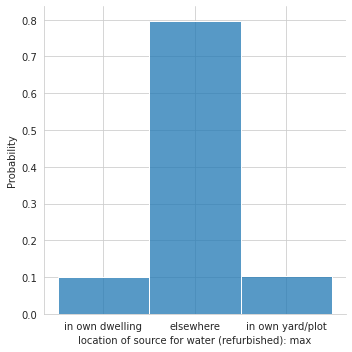

source of drinking water (categorized piped):
asd source of drinking water (categorized piped): max    20184
Name: source of drinking water (categorized piped): groundwater, dtype: int64
asd source of drinking water (categorized piped): max    10768
Name: source of drinking water (categorized piped): other piped, dtype: int64
asd source of drinking water (categorized piped): max    3354
Name: source of drinking water (categorized piped): piped into dwelling, dtype: int64
asd source of drinking water (categorized piped): max    2921
Name: source of drinking water (categorized piped): surface water, dtype: int64
asd source of drinking water (categorized piped): max    755
Name: source of drinking water (categorized piped): bottled, dtype: int64
asd source of drinking water (categorized piped): max    317
Name: source of drinking water (categorized piped): other, dtype: int64
asd source of drinking water (categorized piped): max    306
Name: source of drinking water (categorized piped): s

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



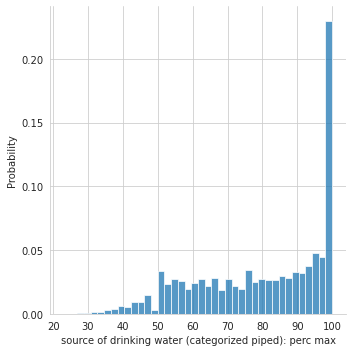

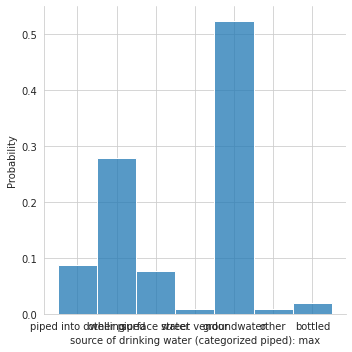

source of drinking water (categorized piped 2):
asd source of drinking water (categorized piped 2): max    20645
Name: source of drinking water (categorized piped 2): groundwater, dtype: int64
asd source of drinking water (categorized piped 2): max    5412
Name: source of drinking water (categorized piped 2): public tap/standpipe, dtype: int64
asd source of drinking water (categorized piped 2): max    3814
Name: source of drinking water (categorized piped 2): piped into dwelling, dtype: int64
asd source of drinking water (categorized piped 2): max    3457
Name: source of drinking water (categorized piped 2): piped to yard/plot, dtype: int64
asd source of drinking water (categorized piped 2): max    2946
Name: source of drinking water (categorized piped 2): surface water, dtype: int64
asd source of drinking water (categorized piped 2): max    836
Name: source of drinking water (categorized piped 2): bottled, dtype: int64
asd source of drinking water (categorized piped 2): max    823
Nam

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



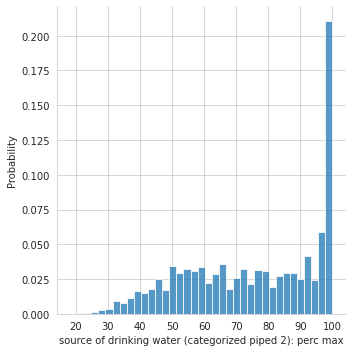

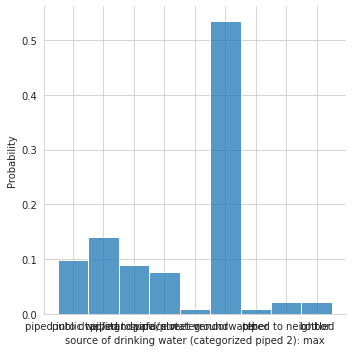

source of drinking water (categorized piped 3):
asd source of drinking water (categorized piped 3): max    20519
Name: source of drinking water (categorized piped 3): groundwater, dtype: int64
asd source of drinking water (categorized piped 3): max    6744
Name: source of drinking water (categorized piped 3): piped (public/neighbor), dtype: int64
asd source of drinking water (categorized piped 3): max    3718
Name: source of drinking water (categorized piped 3): piped into dwelling, dtype: int64
asd source of drinking water (categorized piped 3): max    3212
Name: source of drinking water (categorized piped 3): piped to yard/plot, dtype: int64
asd source of drinking water (categorized piped 3): max    2941
Name: source of drinking water (categorized piped 3): surface water, dtype: int64
asd source of drinking water (categorized piped 3): max    808
Name: source of drinking water (categorized piped 3): bottled, dtype: int64
asd source of drinking water (categorized piped 3): max    339


/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_544215/4221531805.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



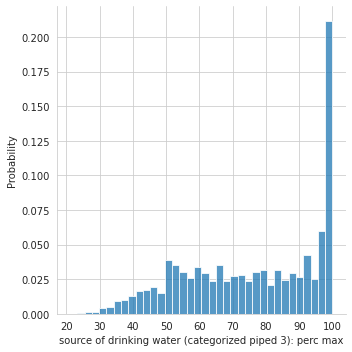

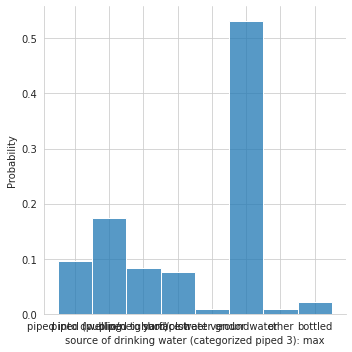

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwel

In [45]:
cluster_df6 = cluster_df5
for pre in ["source of drinking water (simplified)", "source of drinking water (categorized by type)",
            "source of drinking water (categorized urban)",
            "source of drinking water (categorized)", "source of drinking water (weights)", 
            "location of source for water (refurbished)",
           "source of drinking water (categorized piped)", "source of drinking water (categorized piped 2)",
           "source of drinking water (categorized piped 3)"]:
    pre += ':'
    select_cols = ["DHSID", "URBAN_RURA"]
    for col in cluster_df5.columns:
        if pre in col:
            select_cols.append(col)
    sub_df = cluster_df5[select_cols].copy()
    print(pre)
    # print(sub_df)
    sub_df[pre + ' max'] = sub_df[select_cols[2:]].idxmax(axis=1)
#     print(sub_df[pre + ' max'])
    for i, x in pd.DataFrame(sub_df[pre + ' max'].value_counts()).iterrows():
        print('asd', x)
#     print(pd.DataFrame(sub_df[pre + ' max'].value_counts()))
    replace_d = {pre + ' max': {c: c[len(pre) + 1:] for c, v in 
                                     pd.DataFrame(sub_df[pre + ' max'].value_counts()).iterrows()}}
    print(replace_d)
    sub_df = sub_df.replace(replace_d)
    # print(sub_df)
    # print(pre)
    sub_df[pre + ' perc max'] = sub_df[select_cols[1:]].max(axis=1) / sub_df[select_cols[1:]].sum(axis=1) * 100
    # print(sub_df[pre + ' max'].value_counts(dropna=False))
#     plot perc max    
#     bins = list(range(1, 101, 5))
#     print(bins)
#     hist = sub_df[pre + ' perc max'].plot.hist(bins=bins)#, density=True)
#     plt.xlim(-5, 315)
#     plt.title(pre[:-1])
#     plt.xlabel("percentage of highest label")
#     plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#     sub_df = sub_df[sub_df['URBAN_RURA'] == 'U']
    sns.displot(sub_df[pre + ' perc max'], stat='probability')
    ax2 = sns.displot(sub_df[pre + ' max'], stat='probability')
    for ax in [ax2]:
        if 'max' in col and not 'perc' in col or col == 'distance categories cluster':
            ax.set_xticklabels(rotation=90)
    plt.show()

    cluster_df6 = pd.merge(cluster_df6, sub_df[["DHSID", pre + ' max', pre + ' perc max']], how="outer", on=['DHSID'])
    
cluster_df6

In [46]:
#drop na values
pd.set_option('display.float_format', lambda x: '%.10f' % x)
cluster_df6 = cluster_df6[cluster_df6["source of drinking water (simplified): max"].notna()]
cluster_df6 = cluster_df6[cluster_df6["LATNUM"].notna()]
print(len(cluster_df6))
#remove (0,0) pairs
cluster_df6 = cluster_df6[~cluster_df6["LATNUM"].between(0.000000000, 0.00000001)]#5.68434188609e-14)]
print(len(cluster_df6))
cluster_df6["LATNUM"].value_counts(dropna=False)
# cluster_df6[cluster_df6["LATNUM"] == 5.5486260000]

38177
38154


5.5486260000      2
12.8691570000     2
6.6745950000      2
5.8079750000      2
12.6653550000     2
                 ..
-0.3097660000     1
-0.2045710000     1
-0.4954240000     1
-0.4305890000     1
-17.8591140000    1
Name: LATNUM, Length: 38141, dtype: int64

In [47]:
cluster_df6['distance categories cluster'] = np.NaN
replace_l = [-1, 0, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        cluster_df6['distance categories cluster'] = np.where(cluster_df6[
            'time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             cluster_df6['distance categories cluster'])
cluster_df6['distance categories cluster 2'] = np.NaN
replace_l = [-1, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        cluster_df6['distance categories cluster 2'] = np.where(cluster_df6[
            'time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             cluster_df6['distance categories cluster 2'])
cluster_df6

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwel

In [48]:
def split_label_df(df_in, sub_df_ind, value_col, force_split_col2, split_col_n, img_path, excl_outlier, force_test_ind, force_into, since_year=2012, split_amount=6, excl_outlier_std=1, assign_test=False):
    """
    Split the label DataFrame according to an x-cross evaluation.

    Parameters
    ----------
    df_in : pandas.DataFrame
        The input label DataFrame to split.
    mode : str
        The mode to use for splitting and labeling the DataFrame. Valid options include:
            - 'split: random': Randomly split the DataFrame into `split_amount` splits.
            - 'split: without <2015': Split the DataFrame into `split_amount` splits, but exclude any rows with a DHSYEAR less than 2015.
            - 'split: country year': Split the DataFrame by unique values of the `GEID` column, ensuring that each split does not contain multiple surveys from the same country.
            - 'split: out of country': Split the DataFrame by unique values of the first two characters of the `GEID` column.
    sub_df_ind : str or bool, optional
        If 'rural', only include rows where the `URBAN_RURA` column is 'R'. If 'urban', only include rows where the `URBAN_RURA` column is 'U'. If 'all' (default) or False, include all rows.
    split_amount : int, optional
        The number of splits to create (default 6).
    last_split_as_test : bool, optional
        If True (default), the last split will be labeled as 'test' instead of 'split N'.
    force_test_ind : str or bool, optional
        If a string is provided, any split containing a row with a value of `force_test_ind` in the column used for splitting will be labeled as 'test'.
         E.g 'MZ' ('split: out of country') or 'MZGE7AFL' ('split: out of country') can be provided to put Mozambique (2018) into the test set.
         If False (default), this behavior is disabled.
    img_path : bool, str
        If the path to the geotiff folder is passed omits rows where there are no geotiffs available else False

    Returns
    -------
    pandas.DataFrame
        The input DataFrame with an additional column indicating the split based on the chosen mode.
    """
    df_in = df_in.copy()
    df = prepare_df(df_in, sub_df_ind, img_path, excl_outlier, excl_outlier_std, split_col_n, value_col, since_year=since_year)
#     print('1.1', df[split_col_n].value_counts())

    if 'split: random' in split_col_n:
        df = df.sample(frac=1)
        for i in range(0, split_amount):
            df[split_col_n].iloc[int(len(df)/split_amount) * (i): int(len(df)/split_amount) * (i+1)] = 'split ' + str(i)

        if assign_test:
            scores = hu.statistical_weighted_test_set(df, split_col_n, value_col)
            df.loc[df[split_col_n] == scores[0][0], split_col_n] = 'test'
        df_in = pd.merge(df_in, df[["DHSID", split_col_n]], how="outer", on=['DHSID'])
    else:
        column = 'split col'
        if 'year' in split_col_n:
            df[column] = df[force_split_col2] + df['DHSYEAR'].astype(int).astype(str)
        else:
            df[column] = df[force_split_col2]

        # Shuffle the dataframe
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
        # Get the unique values of the categorical column
        unique_values = df_shuffled[column].unique()
        # Initialize a dictionary to store the rows for each unique value
        value_rows = {value: df_shuffled[df_shuffled[column] == value] for value in unique_values}
        #print(value_rows)
        # Sort the unique values by decreasing order of count
        sorted_values = {k: v for k, v in sorted(value_rows.items(), key=lambda item: len(item[1]), reverse=True)}
        sorted_dfs = [pd.DataFrame(columns=df.columns) for i in range(split_amount)]
        look_up_d = {i: {} for i in range(split_amount)}
        look_up_d_new = {}
        for unique_value, sub_df in sorted_values.items():
            if sub_df[force_split_col2].iloc[0] not in look_up_d:
                look_up_d_new[sub_df[force_split_col2].iloc[0]] = {}
            if 'year' in split_col_n:
                #make sure that it will be sorted into a split where the same country is not in it right now
                put_into_split = False
                for nr, sdf in enumerate(sorted_dfs):
                    if nr not in look_up_d_new[sub_df[force_split_col2].iloc[0]]:
                        look_up_d_new[sub_df[force_split_col2].iloc[0]][nr] = set([])
                    if sub_df['adm0_name'].iloc[0] not in look_up_d_new[sub_df[force_split_col2].iloc[0]][nr]:
                        sorted_dfs[nr] = pd.concat([sdf, sub_df])
                        look_up_d_new[sub_df[force_split_col2].iloc[0]][nr].add(sub_df['adm0_name'].iloc[0])
                        put_into_split = True
                        break
                if not put_into_split:
                    #we exceeded the amount of splits
                    sub_df2 = pd.DataFrame(df[column].value_counts()).reset_index()
                    sub_df2.columns = [column, 'amount']
                    print('value counts\n', sub_df2)
                    print(split_col_n)
                    # print(look_up_d[sub_df['adm0_name'].iloc[0]])
                    print(f"To many surveys for {sub_df[force_split_col2].iloc[0]} cannot sort in without putting multiple surveys of that country into one split")
                    #sort the following by the amount of unique values
                    print(df.groupby(force_split_col2)[column].nunique().sort_values())
                    # print(df.groupby(force_split_col2)[column].unique())
                    print(df[df[force_split_col2] == sub_df[force_split_col2].iloc[0]][['DHSYEAR', 'GEID', force_split_col2, 'adm0_name']].value_counts())
                    raise NotImplementedError("Possibly just raise the amount of splits")
            else:
                #concat the sub_df of unique_value to the shortest df
                sorted_dfs[0] = pd.concat([sorted_dfs[0], sub_df])
            #sort so that always the df with the least amount of rows is on pos 0
            sorted_dfs = sorted(sorted_dfs, key=lambda x: len(x))

        #stick everything together
        fdf = pd.concat([sdf for sdf in sorted_dfs])
        df_in = pd.merge(df_in, fdf[["DHSID", split_col_n]], how="outer", on=['DHSID'])

        if assign_test:
            #assign a test split to either Mozambique or to split 0
            if force_test_ind:
                if isinstance(force_test_ind, str):
                    if force_into:
                        test_split_n = df_in[df_in['adm0_name'] == force_test_ind][split_col_n].iloc[0]
                    else:
                        for test_split_n in df_in[split_col_n].unique():
                            if force_test_ind not in df_in[df_in[split_col_n] == test_split_n]['adm0_name']:
                                break
                        else:
                            raise ValueError(f'This should not happen force_test_ind is {force_test_ind}')
                elif isinstance(force_test_ind, tuple):
                    if force_into:
                        test_split_n = df_in[(df_in['adm0_name'] == force_test_ind[0]) & (df_in['DHSYEAR'] == force_test_ind[1])][split_col_n].iloc[0]
                    else:
                        for test_split_n in df_in[split_col_n].unique():
                            #make sure force_test_ind (adm0_name) is not in the test split (every Moz survey should be in the train split)
                            if force_test_ind[0] not in df_in[df_in[split_col_n] == test_split_n]['adm0_name']:
                                break
                        else:
                            raise ValueError(f'This should not happen force_test_ind is {force_test_ind}')
                else:
                    raise ValueError(f'This should not happen force_test_ind is {force_test_ind}')
            else:
                scores = hu.statistical_weighted_test_set(df, split_col_n, value_col)
                test_split_n = scores[0][0]
            df_in.loc[df_in[split_col_n] == test_split_n, split_col_n] = 'test'
    return df_in

In [49]:
def prepare_df(df_in, sub_df_ind, img_path, excl_outlier, excl_outlier_std, split_col_n, value_col=False, since_year=2012):
    df = df_in.copy()
    df[split_col_n] = np.NaN
    if since_year:
        df = df[df['DHSYEAR'] >= since_year]
    #restrict to specified area type
    if sub_df_ind == 'rural':
        df = df[df['URBAN_RURA'] == 'R']
    elif sub_df_ind == 'urban':
        df = df[df['URBAN_RURA'] == 'U']
    elif sub_df_ind is False or sub_df_ind == 'all':
        pass
    else:
        raise NotImplementedError()
    #reducing to available images
    if img_path:
        available_files = hu.files_in_folder(img_path, return_pathes=False)
        df["TIF_name"] = df['TIF_name'].apply(lambda x: x if x in available_files else np.NaN)
        df = df[df["TIF_name"].notna()]
    if excl_outlier:
        #excluding outlier surveys (e.g. Egypt, South-Africa)
        df = df[~df['GEID'].isin(drop_survey)]
        if excl_outlier == 'std':
            mean = df[value_col].mean()
            std = df[value_col].std()
            print(split_col_n, value_col, 'mean:', mean, 'STD', std)
            for cy in df["GEID"].unique():
                sub_df = df[df["GEID"] == cy]
                sub_mean = sub_df[value_col].mean()
                # print('sub_mean', sub_mean, 'vs', mean, 'std', std, 'exclstd', excl_outlier_std)
                if sub_mean > mean + excl_outlier_std * std or sub_mean < mean - excl_outlier_std * std:
                    print('dropping', cy, 'amount:', len(sub_df), 'mean:', sub_mean, 'vs', mean)
                    vis.standard_hist_from_df(sub_df[value_col], projects_p + '/imgs/excl_surveys/', cy, sub_df['adm0_name'].iloc[0] + '_' + str(int(sub_df['DHSYEAR'].iloc[0])))
                    #iteratively removing surveys with high deviation of parent distribution (measured on mean)
                    df = df[df["GEID"] != cy]
    df = df[(df[value_col] >= df[value_col].mean() - 3.5 * df[value_col].std()) & (df[value_col] <= df[value_col].mean() + 3.5 * df[value_col].std())]
    return df


def visualize_splits(df, value_col, split_col_n):
    print('\n', f"{split_col_n} size={len(df[value_col])}, mean={df[value_col].mean():.2f}, std={df[value_col].std():.2f}, min={df[value_col].min():.2f}, max={df[value_col].max():.2f} (Whole ds)")
    vis.standard_hist_from_df(df[value_col], projects_p + '/imgs/splits/', split_col_n, title_in='Whole DS', minv=-3.5, maxv=3.5)
    sub_df = df[df[split_col_n].notna()]
    vis.standard_hist_from_df(sub_df[value_col], projects_p + '/imgs/splits/', split_col_n, title_in='WO excluded', minv=-3.5, maxv=3.5)
    print(split_col_n, f'size={len(sub_df[value_col])}, mean={sub_df[value_col].mean():.2f}, std={sub_df[value_col].std():.2f}, min={sub_df[value_col].min():.2f}, max={sub_df[value_col].max():.2f} (Whole ds without excluded areas)')
    means = []
    stds = []
    sizes = []
    for s in df[split_col_n].unique():
        split_data = df[df[split_col_n] == s][value_col]
        #test for isna with possible str input
        if pd.isnull(s):
            split_data = df[df[split_col_n].isna()][value_col]
            s = '                      NAN'
        else:
            means.append(split_data.mean())
            stds.append(split_data.std())
            sizes.append(len(split_data))
        # if np.isnan(s):
        #     split_data = df[df[split_col_n].isna()][value_col]
        print(f"{split_col_n} {s}: size={len(split_data)}, mean={split_data.mean():.2f}, std={split_data.std():.2f}, min={split_data.min():.2f}, max={split_data.max():.2f}")
        vis.standard_hist_from_df(sub_df[value_col], projects_p + '/imgs/splits/', split_col_n, title_in=s, minv=-3.5, maxv=3.5)
    print(f"{split_col_n} std of means: {np.std(means):.2f}, std of stds: {np.std(stds):.2f}, std of sizes {np.std(sizes):.2f}")


#write a function that statistically compares the different splits
def stats_of_splits(df, value_col, split_col_n, force_split_col, split_dict):
    split_dict[split_col_n] = {}
    means = []
    stds = []
    sizes = []
    for v in ['mean', 'std', 'size', 'skew', 'kurtosis']:
        for spl in list(df[split_col_n].unique()) + ['whole ds', 'without excluded areas and imgs']:
            #how to break here if spl is not a number?
            if pd.isnull(spl):
                continue
            if spl == 'whole ds':
                sub_df = df[value_col]
            elif spl == 'without excluded areas and imgs':
                sub_df = df[df[split_col_n].notna()][value_col]
            else:
                sub_df = df[df[split_col_n] == spl][value_col]
            n = spl + ' ' + v
            if v == 'mean':
                split_dict[split_col_n][n] = sub_df.mean()
                if spl != 'whole ds' and spl != 'without excluded areas and imgs':
                    means.append(sub_df.mean())
            elif v == 'std':
                split_dict[split_col_n][n] = sub_df.std()
                if spl != 'whole ds' and spl != 'without excluded areas and imgs':
                    stds.append(sub_df.std())
            elif v == 'size':
                split_dict[split_col_n][n] = int(len(sub_df))
                if spl != 'whole ds' and spl != 'without excluded areas and imgs':
                    sizes.append(int(len(sub_df)))
            elif v == 'skew':
                split_dict[split_col_n][n] = sub_df.skew()
            elif v == 'kurtosis':
                split_dict[split_col_n][n] = sub_df.kurtosis()
    split_dict[split_col_n]['std of means'] = np.std(means)
    split_dict[split_col_n]['std of stds'] = np.std(stds)
    split_dict[split_col_n]['std of sizes'] = np.std(sizes)
    # stats_df = pd.DataFrame(split_dict)
    return split_dict


def split_df_accounting_for_mean(df_in, sub_df_ind, value_col, force_split_col, split_col_n, img_path, excl_outlier, force_test_ind, force_into, since_year, n_splits=6, excl_outlier_std=1, assign_test=False):
    df = df_in.copy()
    data = prepare_df(df, sub_df_ind, img_path, excl_outlier, excl_outlier_std, split_col_n, value_col=value_col, since_year=since_year)
    parent_mean, parent_std = data[value_col].agg(['mean', 'std'])

    split_columns = [force_split_col]
    if 'year' in split_col_n:
        split_columns.append('DHSYEAR')
    if 'adm0_name' not in split_columns:
        split_columns.append('adm0_name')

    stats_df = data.groupby(split_columns)[value_col].agg(['mean', 'count']).reset_index()
    # stats_df = stats_df[stats_df['mean'].notna()]
    stats_df['mean_diff_w'] = (stats_df['mean'] - parent_mean) * stats_df['count']/stats_df['count'].mean()
    stats_df['mean_abs_w'] = np.abs(stats_df['mean_diff_w'])
    #create a balanced weighting from 'mean_abs_w' and 'count'
    stats_df['sort_score'] = stats_df['mean_abs_w']/stats_df['mean_abs_w'].std() + (stats_df['count'] - stats_df['count'].mean()) / stats_df['count'].std()
    stats_df = stats_df.sort_values(['sort_score'], ascending=[False])
    print(stats_df)
    splits = [[] for _ in range(n_splits)]

    #check if other years of the same are already have been added to the split
    look_up_d = {i: {} for i in range(n_splits)}
    for k, (j, row1) in enumerate(stats_df.iterrows()):
        best_split = None
        min_score = float('inf')
        str_l = []
        for nr, split in enumerate(splits):
            if row1['adm0_name'] not in look_up_d[nr]:
                look_up_d[nr][row1['adm0_name']] = set([])

            temp_split = split + [row1]
            if split:
                try:
                    combined_mean_diff = np.nanmean([row['mean_diff_w'] for row in split])
                except RuntimeWarning as e:
                    print(e)
                    combined_mean_diff = 0
            else:
                combined_mean_diff = 0
            try:
                combined_mean_diff_new = np.nanmean([row['mean_diff_w'] for row in temp_split])
            #also print Warning if the mean is nan
            except RuntimeWarning as e:
                print(e)
                combined_mean_diff_new = 0

            #add penalty if the mean goes into the wrong direction
            if len(split) == 0:
                score = 0
            #add penalty if the mean goes into the wrong direction
            elif combined_mean_diff <= 0 <= row1['mean_diff_w'] or row1['mean_diff_w'] <= 0 <= combined_mean_diff:
                #if the mean switches from negative to positive, add the difference as a penalty else use it as a weighting to force the furthest away to have a high chance to be added
                if combined_mean_diff <= 0 <= combined_mean_diff_new or combined_mean_diff_new <= 0 <= combined_mean_diff:
                    score = abs(combined_mean_diff_new)
                else:
                    score = -abs(combined_mean_diff_new)
            else:
                #if it is pointing into the wrong direction, add it as a penalty though
                score = abs(combined_mean_diff_new) + abs(combined_mean_diff_new)

            # Calculate the penalty based on the difference of summed counts between the splits
            counts = [sum([r['count'] for r in s] + [row1['count']]) for s in splits]
            count_local = sum([r['count'] for r in split]) + row1['count']
            count_penalty = 1 * max(parent_std, abs(combined_mean_diff_new)) * (count_local - np.min(counts))/count_local * (len(stats_df)/2 + k/2)/len(stats_df)
            score += count_penalty
            str_l.append([nr, count_local, score, combined_mean_diff, combined_mean_diff_new, count_penalty, row1['mean_diff_w'], row1['count']])

            if score < min_score and ('year' not in split_col_n or row1[force_split_col] not in look_up_d[nr][row1['adm0_name']]):
                min_score = score
                best_split = nr
        # print('appending', 'to', best_split)
        if best_split is None:
            print(split_col_n)
            #sort the following by the amount of unique values
            # print(data.groupby(force_split_col)[force_split_col].nunique().sort_values())
            print(df[df[force_split_col] == row1[force_split_col]][['DHSYEAR', 'GEID', force_split_col, 'adm0_name']].value_counts())
            print(stats_df[stats_df[force_split_col] == row1[force_split_col]][split_columns].value_counts())
            print(f"To many surveys for {row1[force_split_col]} cannot sort in without putting multiple surveys of that country into one split")
            raise NotImplementedError("Possibly just raise the amount of splits")

        # if str_l[best_split][1] == max(c[1] for c in str_l) and k >= 2:
        # print(best_split)
        # for str_gen in str_l:
        #     print(f"k {k} split {str_gen[0]} count {str_gen[1]} score {str_gen[2]} combined_mean_diff {str_gen[3]} combined_mean_diff_new {str_gen[4]} count_penalty {str_gen[5]} row mean diff w {str_gen[6]} row count {str_gen[7]}")
        splits[best_split].append(row1)
        look_up_d[best_split][row1['adm0_name']].add(row1[force_split_col])

    # Create a dictionary to map group keys (tuple of values from groupby_cols) to their split assignments
    split_assignments = {tuple(row[split_columns]): i for i, country_group in enumerate(splits) for row in country_group}
    # Update the 'Split' column in the input data with the split assignments
    data[split_col_n] = data[split_columns].apply(lambda x: f'split {split_assignments[tuple(x)]}', axis=1)

    if assign_test:
        #assign a test split to either Mozambique or to split 0
        if force_test_ind:
            if isinstance(force_test_ind, str):
                if force_into:
                    test_split_n = data[data['adm0_name'] == force_test_ind][split_col_n].iloc[0]
                else:
                    for test_split_n in data[split_col_n].unique():
                        if force_test_ind not in data[data[split_col_n] == test_split_n]['adm0_name']:
                            break
                    else:
                        raise ValueError(f'This should not happen force_test_ind is {force_test_ind}')
            elif isinstance(force_test_ind, tuple):
                if force_into:
                    test_split_n = data[(data['adm0_name'] == force_test_ind[0]) & (data['DHSYEAR'] == force_test_ind[1])][split_col_n].iloc[0]
                else:
                    for test_split_n in data[split_col_n].unique():
                        #make sure force_test_ind (adm0_name) is not in the test split (every Moz survey should be in the train split)
                        if force_test_ind[0] not in data[data[split_col_n] == test_split_n]['adm0_name']:
                            break
                    else:
                        raise ValueError(f'This should not happen force_test_ind is {force_test_ind}')
            else:
                raise ValueError(f'This should not happen force_test_ind is {force_test_ind}')
        else:
            #create mean and std weighted scores
            scores = hu.statistical_weighted_test_set(df, split_col_n, value_col)
            test_split_n = scores[0][0]
        data.loc[data[split_col_n] == test_split_n, split_col_n] = 'test'

    df_in = pd.merge(df_in, data[["DHSID", split_col_n]], how="left", on='DHSID')
    return df_in

In [62]:
cluster_df7 = cluster_df6.copy()
cluster_df8 = cluster_df7.copy()
inputs_split_df_accounting_for_mean = []
inputs_split_label_df = []
stats_d = {}
for mode in [
    'split: random', 'split: random 10splits',
    'split: non overlapping',
    'split: out of country',
    'split: out of adm1',
    'split: out of adm2',
        ]:
    for sub_df_ind in ['all', 'rural', 'urban']:
        for img_p in [img_path]:#, False]:
            for excl_outlier in [False, True, 'std']:
                # for random in [False, True]:
                for year in [False, True]:
                    # for force_into in [True, False]:
                        for since_year in [2012]:#, 2015]:
                            split_col_n = mode
                            #skip stuff which does not make sense
                            if year:
                                #does not make sense for these
                                if 'split: random' in split_col_n or 'split: random without <2015' in split_col_n:
                                    continue
                            # if not random:
                            #     # if 'adm2' in split_col_n:
                            #     #     print('skipping adm2 split_df_accounting_for_mean')
                            #     #     #algo split_df_accounting_for_mean not working for adm2
                            #     #     continue
                            #     if 'split: random' in split_col_n or 'split: random without <2015' in split_col_n:
                            #         continue
                            # if force_into:
                            #     #skip all which
                            #     if not 'split: out of country' in split_col_n:
                            #         continue

                            #define the column which will be used for calculation
                            if sub_df_ind == 'all':
                                value_col = 'PCA w_location_weighting all'
                            elif sub_df_ind == 'rural':
                                value_col = 'PCA w_location_weighting rural'
                            elif sub_df_ind == 'urban':
                                value_col = 'PCA w_location_weighting urban'
                            else:
                                raise NotImplementedError()

                            if year:
                                split_col_n += ' year'
                            split_col_n += ' ' + sub_df_ind
                            # if not img_p:
                            #     split_col_n += ' (wo TIF)'
                            if since_year:
                                split_col_n += f' {since_year}plus'
                            if excl_outlier == 'std':
                                split_col_n += ' excluded outlier surveys'
                            elif excl_outlier == drop_survey or excl_outlier is True:
                                split_col_n += ' excluded drop surveys (ZAuEG)'
                            random = False
                            if 'random' in split_col_n:
                                random = True
                            # if random:
                            #     #no doulbe random in name
                            #     if 'split: random' in split_col_n or 'split: random without <2015' in split_col_n:
                            #         pass
                            #     else:
                            #         split_col_n += ' random'
                            splits = 6
                            if '10splits' in col_n:
                                splits = 10

                            # else:
                            #     raise ValueError(f'Should not happen: random is {random} and year is {year}')
                            force_test_ind = False
                            force_into = False
                            # if 'split: out of country' in split_col_n:
                            #     force_test_ind = 'Mozambique'
                            #     if force_into:
                            #         split_col_n += ' MZ in test'
                            #     else:
                            #         split_col_n += ' MZ in train'
                            #     if 'year' in split_col_n:
                            #         force_test_ind = ('Mozambique', 2018)

                            force_split_col = False
                            if 'split: out of country' in split_col_n:
                                force_split_col = 'adm0_name'
                            elif 'split: out of adm1' in split_col_n:
                                force_split_col = 'adm1_name'
                            elif 'split: out of adm2' in split_col_n:
                                force_split_col = 'adm2_name'

                            df_in = cluster_df8
                            if 'split: non overlapping' in split_col_n:
                                #calc distance for overlapping, use 10% buffer to ensure with haversine, use pythagoras to ensure there are no overlaps in the corners as well, using 5km radius for now
                                dist = np.sqrt((5 * 1.1) ** 2 + (5 * 1.1) ** 2)
                                df_in = cluster_df8[cluster_df8['DHSYEAR'] >= since_year]
                                df_in = gu.cluster_coordinates(df_in, dist, assign_noise_to_groups=30)
                                numeric_cols = df_in.select_dtypes(include=[np.number]).columns.tolist()
                                for col in ['clustered']:
                                    if col in numeric_cols:
                                        numeric_cols.remove(col)
                                clustered = df_in[df_in['clustered'] != -1].groupby('clustered')[numeric_cols].mean()
                                clustered = clustered.reset_index()
                                clustered.to_csv(f'{out_f[:-4]}_clustered_{sub_df_ind}_since{since_year}_{dist:.2f}km.csv', index=False)
                                force_split_col = 'clustered: grouped non-clustered'

                            print(split_col_n)
                            if not random:
                                # print('split_df_accounting_for_mean', split_col_n, force_test_ind, value_col)
                                # print(f'sub_df_ind {sub_df_ind}, value_col {value_col}, force_split_col {force_split_col}, split_col_n {split_col_n}, img_p {img_p}, value_column {excl_outlier}, force_test_ind={force_test_ind}')
                                # print('in', sub_df_ind, value_col, force_split_col, split_col_n, img_p, excl_outlier, force_test_ind, force_into)
                                inputs_split_df_accounting_for_mean.append((df_in.copy(), sub_df_ind, value_col, force_split_col, split_col_n, img_p, excl_outlier, force_test_ind, force_into, since_year, splits))
                                # cluster_df7s = split_df_accounting_for_mean(cluster_df7, sub_df_ind, value_col, force_split_col, split_col_n, img_p, excl_outlier, force_test_ind=force_test_ind, force_into=force_into)
                                # cluster_df7[split_col_n] = cluster_df7s
                            else:
                                # print('split_label_df', split_col_n, force_test_ind, value_col)
                                inputs_split_label_df.append((df_in.copy(), sub_df_ind, value_col, force_split_col, split_col_n, img_p, excl_outlier, force_test_ind, force_into, since_year, splits))
                                # cluster_df7 = split_label_df(cluster_df7, value_col, sub_df_ind, split_col_n, force_split_col, force_test_ind=force_test_ind, img_path=img_p, excl_outlier=excl_outlier, force_into=force_into)
                            # visualize_splits(cluster_df7, value_col, split_col_n, force_split_col)
                            # stats_d = stats_of_splits(cluster_df7, value_col, split_col_n, force_split_col, stats_d)

def helper(params, func):
    return func(*params)

#calc split_df_accounting_for_mean
print('starting calc', len(inputs_split_df_accounting_for_mean))
with ProcessPoolExecutor() as executor:
    results1 = executor.map(partial(helper, func=split_df_accounting_for_mean), inputs_split_df_accounting_for_mean)
# results1 = []
# for inp in inputs_split_df_accounting_for_mean:
#     results1.append(split_df_accounting_for_mean(*inp))
for inp, df1 in zip(inputs_split_df_accounting_for_mean, results1):
    cluster_df7 = pd.merge(cluster_df7, df1[['DHSID', inp[4]]], on='DHSID', how='left')
print('finished calc split_df_accounting_for_mean')
# print(list(cluster_df7.columns))
for d in inputs_split_df_accounting_for_mean:
    visualize_splits(cluster_df7, d[2], d[4])
    stats_d = stats_of_splits(cluster_df7, d[2], d[4], d[3], stats_d)
print('starting calc', len(inputs_split_label_df))
#calc split_df
# inputs_split_label_df = inputs_split_label_df[:10]
# results2 = []
# for inp in inputs_split_label_df:
#     results2.append(split_label_df(*inp))
with ProcessPoolExecutor() as executor:
    results2 = executor.map(partial(helper, func=split_label_df), inputs_split_label_df)
# concat
for inp, df1 in zip(inputs_split_label_df, results2):
#     print('inp', inp)
#     print('cdf', list(cluster_df7.columns))
#     print('in df', list(df.columns))
    cluster_df7 = pd.merge(cluster_df7, df1[['DHSID', inp[4]]], on='DHSID', how='left')
print('finished calc split_label_df')
for d in inputs_split_label_df:
    visualize_splits(cluster_df7, d[2], d[4])
    stats_d = stats_of_splits(cluster_df7, d[2], d[4], d[3], stats_d)
plt.close('all')
cluster_df7

/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping all 2012plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping all 2015plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year all 2012plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year all 2015plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping all 2012plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping all 2015plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year all 2012plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year all 2015plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping all 2012plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping all 2015plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year all 2012plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year all 2015plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping rural 2012plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping rural 2015plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year rural 2012plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year rural 2015plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping rural 2012plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping rural 2015plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year rural 2012plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year rural 2015plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping rural 2012plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping rural 2015plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year rural 2012plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year rural 2015plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping urban 2012plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping urban 2015plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year urban 2012plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year urban 2015plus


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping urban 2012plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping urban 2015plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year urban 2012plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year urban 2015plus excluded drop surveys (ZAuEG)


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping urban 2012plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping urban 2015plus excluded outlier surveys


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: non overlapping year urban 2012plus excluded outlier surveys
split: non overlapping year urban 2015plus excluded outlier surveys
starting calc 36


/home/sven/pycharm/water_sven/geo_utils.py:149: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/sven/pycharm/water_sven/geo_utils.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



      clustered: grouped non-clustered     adm0_name          mean  count    mean_diff_w    mean_abs_w    sort_score
3043                               132       Burundi -0.1068557154    367 -19.3233380695 19.3233380695 43.7812503652
3045                               132        Rwanda -0.1201762102    353 -19.9909174786 19.9909174786 42.7005125816
3238                               319         Ghana  1.9114867916    126  69.3384065555 69.3384065555 41.6826506120
4267                              1335       Senegal  1.8098286610    113  58.7527226815 58.7527226815 35.8779969340
3380                               472        Gambia  1.3932903087    133  52.6014314409 52.6014314409 35.1949559814
...                                ...           ...           ...    ...            ...           ...           ...
1300                              -106         Kenya  0.0646731481      1  -0.0014098423  0.0014098423 -0.2285644289
2452                               -30        Guinea  0.06505085

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwel

In [51]:
data_list = []
for outer_key, inner_dict in stats_d.items():
    temp_dict = {'Split name': outer_key, **inner_dict}
    data_list.append(temp_dict)
# Create the DataFrame
stats_of_splits_df = pd.DataFrame(data_list)
cols = ['Split name'] + ['std of means', 'std of stds', 'std of sizes'] + [c for c in stats_of_splits_df.columns if 'size' in c and not 'std of' in c] + [c for c in stats_of_splits_df.columns if 'mean' in c and not 'std of' in c] + [c for c in stats_of_splits_df.columns if 'std' in c and not 'std of' in c]
stats_of_splits_df = stats_of_splits_df[cols]
# print(stats_of_splits_df)
# df.set_index('Split name', inplace=True)
stats_of_splits_df.to_csv(out_f[:-4] + 'stats_of_splits.csv')
stats_of_splits_df

,Split name,std of means,std of stds,std of sizes,split 4 size,split 5 size,split 1 size,split 3 size,split 2 size,split 0 size,whole ds size,without excluded areas and imgs size,split 4 mean,split 5 mean,split 1 mean,split 3 mean,split 2 mean,split 0 mean,whole ds mean,without excluded areas and imgs mean,split 4 std,split 5 std,split 1 std,split 3 std,split 2 std,split 0 std,whole ds std,without excluded areas and imgs std
0,split: non overlapping all 2012plus,0.0866559031,0.0570861740,742.7474709183,4633,4632,6626,4633,4633,4634,38154,29791,0.1407565331,0.1407047214,0.3780448878,0.1458727859,0.1422095153,0.1624694740,0.1364755438,0.1979243247,1.1915248143,1.2096035716,1.3557934865,1.2407441104,1.1900359700,1.2155124084,1.2199769729,1.2472670169
1,split: non overlapping all 2015plus,0.0000002560,0.0900474706,0.0000000000,2722,2722,2722,2722,2722,2722,38154,16332,0.0693924230,0.0693922151,0.0693922988,0.0693926979,0.0693929100,0.0693922431,0.1364755438,0.0693924646,1.0757719632,1.1469406884,0.9735077672,1.1746111254,1.1852938462,0.9656968438,1.2199769729,1.0905268993
2,split: non overlapping year all 2012plus,0.0428734978,0.0362740098,249.0237048065,5522,4854,4853,4854,4854,4854,38154,29791,0.2915613787,0.1764909143,0.1756912387,0.1754659928,0.1750451881,0.1804004682,0.1364755438,0.1979243247,1.2794688008,1.3002540097,1.2497341922,1.2048109147,1.2009073013,1.2364888761,1.2199769729,1.2472670169
3,split: non overlapping year all 2015plus,0.0000010534,0.0380227426,0.0000000000,2722,2722,2722,2722,2722,2722,38154,16332,0.0693931175,0.0693914982,0.0693933194,0.0693930684,0.0693932240,0.0693905603,0.1364755438,0.0693924646,1.1335814718,1.1352417680,1.1129274697,1.0582537797,1.0522343862,1.0479466497,1.2199769729,1.0905268993
4,split: non overlapping all 2012plus excluded d...,0.0448862400,0.0710388496,316.6215757371,4342,4342,5198,4647,4342,4341,38154,27212,-0.0600914028,-0.0532888681,0.0668196993,-0.0150030845,-0.0575420099,-0.0476744686,0.1364755438,-0.0246762439,1.0017482520,0.9846428061,1.0656094412,1.0950175122,0.9803086681,0.8722519521,1.2199769729,1.0065874246
5,split: non overlapping all 2015plus excluded d...,0.0249826422,0.0725529683,88.1767480059,2557,2558,2557,2794,2558,2557,38154,15581,-0.0208708276,-0.0236917326,-0.0232895053,0.0446710195,-0.0239348335,-0.0192887982,0.1364755438,-0.0102212538,0.9796579273,0.9917864073,1.0218043886,1.1308436482,1.0191656730,0.8848012906,1.2199769729,1.0094515789
6,split: non overlapping year all 2012plus exclu...,0.0119729303,0.0422836359,74.0892854752,4503,4502,4502,4502,4502,4701,38154,27212,-0.0293715964,-0.0304384938,-0.0301057332,-0.0306837267,-0.0305145837,0.0018836958,0.1364755438,-0.0246762439,1.0338060251,1.0056787324,0.9175253832,1.0325950784,0.9998571951,1.0431918346,1.2199769729,1.0065874246
7,split: non overlapping year all 2015plus exclu...,0.0000012305,0.0491893664,0.3726779962,2597,2597,2596,2597,2597,2597,38154,15581,-0.0102228547,-0.0102225656,-0.0102208725,-0.0102203058,-0.0102193433,-0.0102215809,0.1364755438,-0.0102212538,1.0521979390,0.9336102658,1.0339281615,0.9661255571,1.0736871666,0.9909480458,1.2199769729,1.0094515789
8,split: non overlapping all 2012plus excluded o...,0.0706926472,0.0917156425,676.5597821988,4044,5860,4045,4045,4044,4045,38154,26083,-0.1413629299,0.0521875206,-0.1377223695,-0.1413525927,-0.1380207854,-0.1267581161,0.1364755438,-0.0945291445,0.9244086892,1.0898540853,0.8975907348,0.9218681878,0.8919821423,0.7773182435,1.2199769729,0.9376806043
9,split: non overlapping all 2015plus excluded o...,0.0250147302,0.0635727777,123.7618681178,2432,2432,2432,2601,2433,2754,38154,15084,-0.0948443123,-0.0953922766,-0.0936981732,-0.0494477196,-0.0934716342,-0.0347095176,0.1364755438,-0.0757192626,0.9485374050,0.9254051464,0.8581517775,1.0371537946,0.8783390001,1.0035912505,1.2199769729,0.9465937786


In [52]:
cluster_df6[cluster_df6['adm1_name'] == 'Melaky'][['adm0_name', 'DHSYEAR']]

,adm0_name,DHSYEAR
17145,Madagascar,2011.0000000000
17146,Madagascar,2011.0000000000
17422,Madagascar,2013.0000000000
17423,Madagascar,2013.0000000000
17424,Madagascar,2013.0000000000
17776,Madagascar,2016.0000000000
17777,Madagascar,2016.0000000000
17778,Madagascar,2016.0000000000
17779,Madagascar,2016.0000000000
17780,Madagascar,2016.0000000000


In [53]:
cluster_df7

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwel

In [54]:
print()
cluster_df_countrymissmatch = cluster_df7[cluster_df7['adm0_name'] != cluster_df7['country']]
cluster_df_countrymissmatch.to_csv(out_f[:-4] + 'countrymissmatch.csv')
cluster_df_countrymissmatch[['adm0_name', 'country', 'DHSYEAR']]

,adm0_name,country,DHSYEAR
2770,Nigeria,Benin,2017.0000000000
3087,Nigeria,Benin,2017.0000000000
3091,Nigeria,Benin,2017.0000000000
3663,United Republic of Tanzania,Burundi,2012.0000000000
4282,Democratic Republic of the Congo,Congo Democratic Republic,2013.0000000000
...,...,...,...
33680,Democratic Republic of the Congo,Uganda,2010.0000000000
34132,Democratic Republic of the Congo,Uganda,2011.0000000000
35361,Democratic Republic of the Congo,Uganda,2018.0000000000
37203,Democratic Republic of the Congo,Zambia,2018.0000000000


In [55]:
for col_split_in in ['split: random']:
    for area_ind in ['all', 'rural', 'urban']:
        col_split = col_split_in + ' ' + area_ind + ' 2012plus'
        sub_df = cluster_df7[cluster_df7[col_split].notna()]
        for col in sub_df.columns:
            if 'max' in col or 'PCA' in col or col in ['time to get to water source (minutes)',
                                       'time to get to water source (refurbished)', 'time to get to water source (refurbished) + penalty (capped)',
                    'source of drinking water (weights)', 'Std Deviation: time to get to water source (refurbished)',
                                      'distance categories cluster']:
                if 'PCA' in col and not area_ind in col:
                    continue
                sub_sub_df = pd.DataFrame(sub_df[[col, col_split]])
                sub_sub_df = sub_sub_df.dropna()
                if not sub_sub_df.empty:
                    print(col_split)
                    print(col)
                    try:
                        print('len', len(sub_df[col]))
                        print('mean', sub_df[col].mean())
                        print('std', sub_df[col].std())
                    except:
                        pass
                    # print(sub_sub_df)
                    if 'max' in col and not col == 'source of drinking water (simplified): max' and not 'perc max' in col:
                        replace_d = {}
                        values_df = pd.DataFrame(sub_sub_df.value_counts(), columns=[col])
                        for nr, row in enumerate(values_df.iterrows()):
                            print(nr, row)
                            print('asd', row[0][0], row[1][col])
                            if row[1][col] >= len(sub_sub_df[col]) * 0.05:
                                replace_d[row[0][0]] = np.NaN
    #                             if cfg.verbose:
    #                                 print('dropped label:', row[0], 'n:', row[1][col], '< threshold', len(labels_df) * drop)
                        sub_sub_df.replace(replace_d)
                    sub_sub_df = sub_sub_df.dropna()
                    # print(max(sub_sub_df))
                    # print(type(max(sub_sub_df)))
                    # print(sub_sub_df)
    #                 figure = plt.figure(figsize=(2, 1), dpi=300)
    #                 sns.set(font_scale = 1)
                    if not type(max(sub_sub_df[col])) == str and max(sub_sub_df[col]) >= 120:
                        bins = list(range(0, 80, 5))
                        print('% <= 1', len(sub_sub_df[sub_sub_df[col] <= 1])/len(sub_sub_df))
                        ax2 = sns.displot(sub_sub_df[col], stat='probability', bins=bins)
                    else:
                        ax2 = sns.displot(sub_sub_df[col], stat='probability')
                    for ax in [ax2]:
                        if 'max' in col and not 'perc' in col or col == 'distance categories cluster':
                            ax.set_xticklabels(rotation=90)

                    title = col
                    extra_folder = ''
                    x_title = None
    #                 sns.set_style("whitegrid")
                    if col == 'source of drinking water (simplified): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (simplified): perc max':
                        title = 'Source of drinking water'
                    if col == 'PCA w_location_weighting urban':
                        title = 'PCA'
                        x_title = 'PC1'
                    if col == 'PCA w_location_weighting all':
                        title = 'PCA'
                        x_title = 'PC1'
                    if col == 'PCA w_location_weighting rural':
                        title = 'PCA'
                        x_title = 'PC1'
                    if col == 'Std Deviation: PCA w_location_weighting urban':
                        title = 'PCA'
                        x_title = 'Std Deviation of PC1'
                    if col == 'Std Deviation: PCA w_location_weighting all':
                        title = 'PCA'
                        x_title = 'Std Deviation of PC1'
                    if col == 'Std Deviation: PCA w_location_weighting rural':
                        title = 'PCA'
                        x_title = 'Std Deviation of PC1'
                    if col == 'time to get to water source (refurbished)':
                        title = 'Time to get to water source'
                        x_title = 'Distance [mins]'
                    if col == 'location of source for water (refurbished): max':
                        title = 'Location of source for water'
                    if col == 'source of drinking water (categorized urban): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized urban): perc max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped): perc max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped 2): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped 2): perc max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped 3): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped 3): perc max':
                        title = 'Source of drinking water'
                    if title != col:
                        extra_folder = '/chosen/'
                    else:
                        extra_folder = '/others/'
                    if 'perc max' in col:
                        x_title = 'Share of answers in maximum category [%]'

                    title += ' (n=' + str(len(sub_sub_df)) + ')'
                    plt.title(title, fontsize=14)
                    plt.xlabel(x_title, fontsize=14)
                    plt.ylabel('Probability', fontsize=14)
                    plt.grid(True)
    #                 plt.tight_layout()

    #                 plt.tightlayout()
                    plt.savefig(projects_p + '/imgs/' + extra_folder + col_split + '_' + col, dpi=300,
                                bbox_inches="tight", transparent=False)
                    plt.clf()
                    plt.close()

split: random all 2012plus
time to get to water source (minutes)
len 29790
mean 28.29088378645029
std 28.17286532296385
% <= 1 0.0024860399296259468
split: random all 2012plus
source of drinking water (weights)
len 29790
mean 2.830931877751778
std 1.0093170997813459
split: random all 2012plus
time to get to water source (refurbished)
len 29790
mean 20.393663093885838
std 25.16401864992361
% <= 1 0.12463914065122525
split: random all 2012plus
time to get to water source (refurbished) + penalty (capped)
len 29790
mean 27.60042156918964
std 24.073726454953167
% <= 1 0.06176569318563276
split: random all 2012plus
PCA cat_distance all
len 29790
mean 0.17217866716404248
std 1.1228771641200244
split: random all 2012plus
PCA min all
len 29790
mean 0.12618863350236523
std 0.922518497676968
split: random all 2012plus
PCA w_location_weighting all
len 29790
mean 0.19795853381376644
std 1.247273975528285
split: random all 2012plus
PCA w_penalty all
len 29790
mean 0.13341223716148934
std 0.953465419

In [56]:
for col in cluster_df7.columns:
    if 'split' in col:
        print(cluster_df7[col].value_counts(dropna=False, normalize=True)*100)

NaN       21.9190648425
split 1   17.3664622320
split 0   12.1455155423
split 4   12.1428945851
split 3   12.1428945851
split 2   12.1428945851
split 5   12.1402736279
Name: split: non overlapping all 2012plus, dtype: float64
NaN       57.1945274414
split 3    7.1342454264
split 2    7.1342454264
split 5    7.1342454264
split 4    7.1342454264
split 0    7.1342454264
split 1    7.1342454264
Name: split: non overlapping all 2015plus, dtype: float64
NaN       21.9190648425
split 4   14.4729255124
split 5   12.7221261205
split 0   12.7221261205
split 3   12.7221261205
split 2   12.7221261205
split 1   12.7195051633
Name: split: non overlapping year all 2012plus, dtype: float64
NaN       57.1945274414
split 0    7.1342454264
split 5    7.1342454264
split 3    7.1342454264
split 1    7.1342454264
split 2    7.1342454264
split 4    7.1342454264
Name: split: non overlapping year all 2015plus, dtype: float64
NaN       28.6785133931
split 1   13.6237353882
split 3   12.1795879855
split 5   11.3

In [57]:
cluster_df7

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,country,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwel

In [58]:
cluster_df7.to_csv(out_f, index=False)

In [59]:
df["source of drinking water (simplified)"].value_counts()

tube well or borehole    194828
public tap/standpipe     143425
unprotected well         108259
surface water             95315
protected well            85581
piped to yard/plot        82574
piped into dwelling       76115
unprotected spring        52864
protected spring          49638
piped to neighbor         26500
sachet                    21555
street vendor             10847
rainwater                  9022
bottled                    6462
other                      5747
Name: source of drinking water (simplified), dtype: int64

In [60]:
#Export for Pranti/ Imputation
df2 = df[["DHSID", "GEID", "country code and phase", "year of interview", "URBAN_RURA", "region", "source of drinking water (simplified)", "time to get to water source (minutes)", "location of source for water", "anything done to water to make safe to drink",  "source of drinking water (categorized by type)", "source of drinking water (weights)", "water shortages", "PCA w_location_weighting all", "source of drinking water (categorized piped)", "source of drinking water (categorized piped 2)", "source of drinking water (categorized piped 3)"]]
df2.to_csv(out_f_hh, index=False)
df2


,DHSID,GEID,country code and phase,year of interview,URBAN_RURA,region,source of drinking water (simplified),time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,source of drinking water (categorized by type),source of drinking water (weights),water shortages,PCA w_location_weighting all,source of drinking water (categorized piped),source of drinking water (categorized piped 2),source of drinking water (categorized piped 3)
0,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.1366967389,piped into dwelling,piped into dwelling,piped into dwelling
1,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.1366967389,piped into dwelling,piped into dwelling,piped into dwelling
2,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.1366967389,piped into dwelling,piped into dwelling,piped into dwelling
3,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.1366967389,piped into dwelling,piped into dwelling,piped into dwelling
4,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.1366967389,piped into dwelling,piped into dwelling,piped into dwelling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970631,ZW201500000400,ZWGE72FL,ZW7,2015.0000000000,R,mashonaland east,protected well,NaN,in own yard/plot,yes,well,3.0000000000,0.0000000000,1.0102560583,groundwater,groundwater,groundwater
970632,ZW201500000400,ZWGE72FL,ZW7,2015.0000000000,R,mashonaland east,protected well,NaN,in own yard/plot,no,well,3.0000000000,0.0000000000,1.0102560583,groundwater,groundwater,groundwater
970633,ZW201500000400,ZWGE72FL,ZW7,2015.0000000000,R,mashonaland east,unprotected well,10.0000000000,elsewhere,yes,well,2.0000000000,0.0000000000,-0.6260100870,groundwater,groundwater,groundwater
970634,ZW201500000400,ZWGE72FL,ZW7,2015.0000000000,R,mashonaland east,protected well,NaN,in own yard/plot,no,well,3.0000000000,0.0000000000,1.0102560583,groundwater,groundwater,groundwater


In [61]:
### Approach for creating scatter plots between years
## Ideas:
# Closest points for a defined distance (e.g. 5km) in the same year, in another year
# Also possible for adm areas
# Also refer to evaluate_final_dataset() in water_w_regression.py

# import pandas as pd
# import numpy as np
#
# # Haversine distance function
# def haversine(lat1, lon1, lat2, lon2):
#     R = 6371 # Radius of earth in kilometers
#     dlat = np.radians(lat2-lat1)
#     dlon = np.radians(lon2-lon1)
#     a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
#     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
#     return R * c
#
# # Create a synthetic dataframe
# data = {'clustered': [1,1,2,2,2,1,1,2,2,2],
#         'DHSYEAR': [2001,2002,2001,2002,2003,2003,2004,2003,2004,2005],
#         'LATNUM': [10,12,14,16,18,12,14,16,18,20],
#         'LONGNUM': [10,12,14,16,18,12,14,16,18,20]}
# clustered_df = pd.DataFrame(data)
#
# cluster_cols = ['clustered']
#
# # Corrected processing logic
# new_l = []
# for group_name, group in clustered_df.groupby(cluster_cols):
#     print(group_name, group)
#     years = list(sorted(group['DHSYEAR'].unique()))
#     if len(years) >= 2:
#         for y1, y2 in zip(years[:-1], years[1:]):
#             sub1 = group[group['DHSYEAR'] == y1]
#             sub2 = group[group['DHSYEAR'] == y2]
#             print('s', sub1, sub2)
#             for index1, row1 in sub1.iterrows():
#                 sub_d = []
#                 for index2, row2 in sub2.iterrows():
#                     print('r', row1, row2)
#                     sub_d.append((row1, row2, haversine(row1['LATNUM'], row1['LONGNUM'], row2['LATNUM'], row2['LONGNUM'])))
#                 sub_d = sorted(sub_d, key=lambda x: x[2])
#                 new_row = pd.merge(sub_d[0][0].to_frame().T, sub_d[0][1].to_frame().T, on=['clustered'])
#                 new_row['distance'] = sub_d[0][2]
#                 new_l.append(new_row)
# print('l', new_l)
# print('r', new_row)
# scatter_between_years_df = pd.concat(new_l)
#
# print(scatter_between_years_df)
